# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.helpers import map_to_color

# Load data

In [2]:
from scripts.parse_vars import parse_variables, load_config
PATH_VARS = Path("../../geno_simulation.txt")
# Random seed for reproducibility of the flip step
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]);
# Build prefix pattern for filtering
prefix = f"G{G}_L{L}_c{c}_k{k}_M{M}"

# Filter only relevant directories
filtered = [d for d in os.listdir("simulation_data") if d.startswith(prefix)]
# Extract F values and mixed cases
F_values = []
mixed_cases = []

for d in filtered:
    # Check if F is present
    match_F = re.search(r"F([0-9.]+)", d)
    if match_F:
        F_values.append(float(match_F.group(1)))

    # Check if mixed is present
    match_mixed = re.search(r"(mixed_[^/]+)", d)
    if match_mixed:
        mixed_cases.append(match_mixed.group(1))
mixed_cases = [f.split("mixed_")[1] for f in mixed_cases]
mixed_cases = sorted(mixed_cases, key=lambda x: int(x.split("_")[0]))
#base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_values[0]}/genotype"
base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{mixed_cases[0]}"
path_geno = f"{base_path}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete.pkl"))

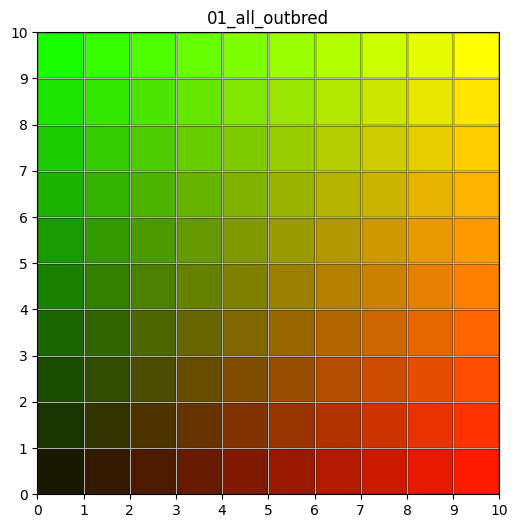

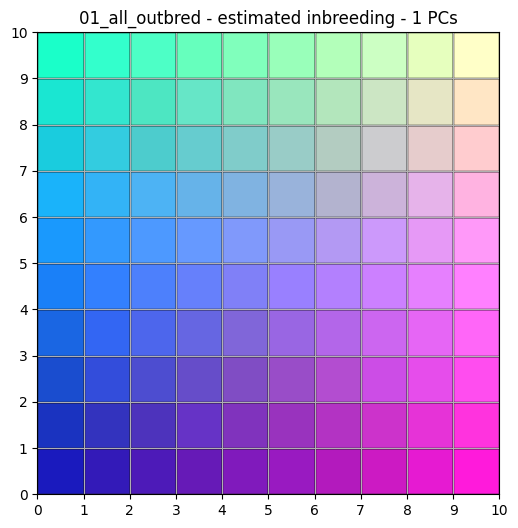

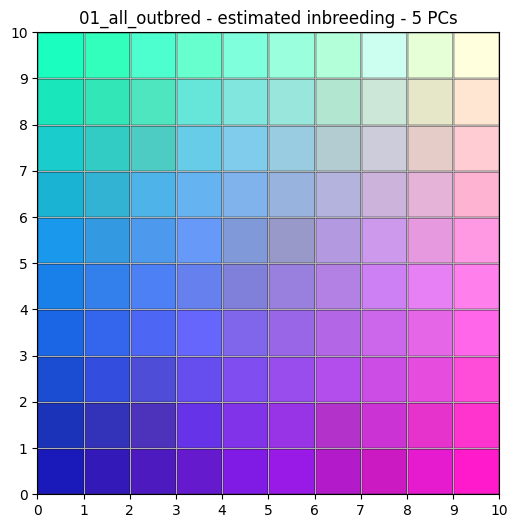

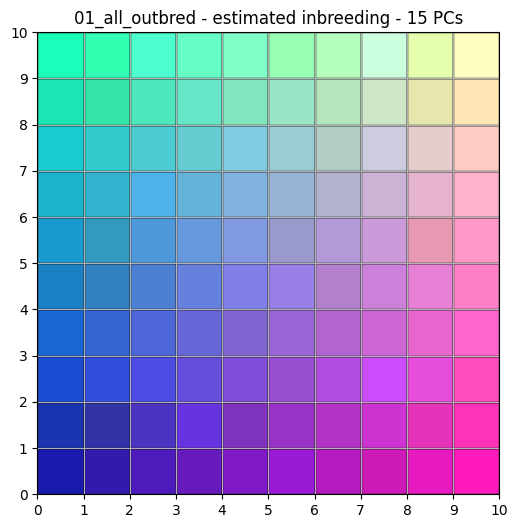

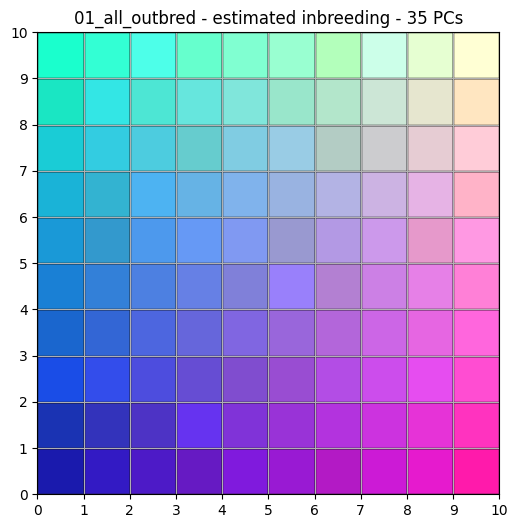

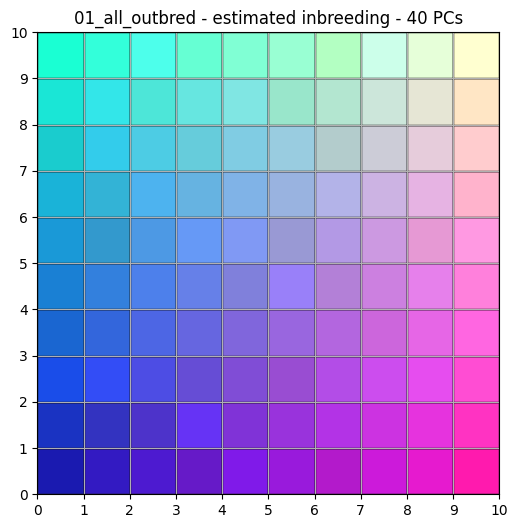

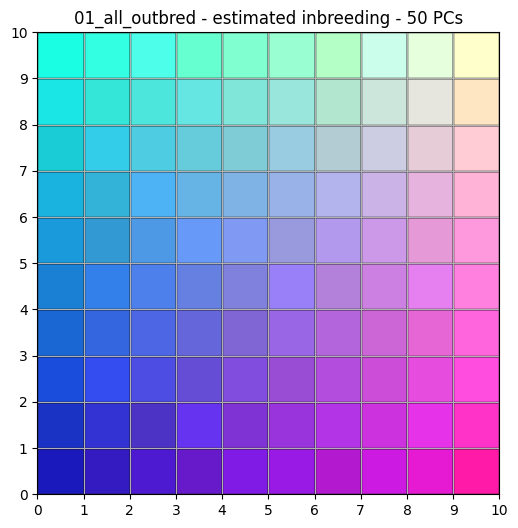

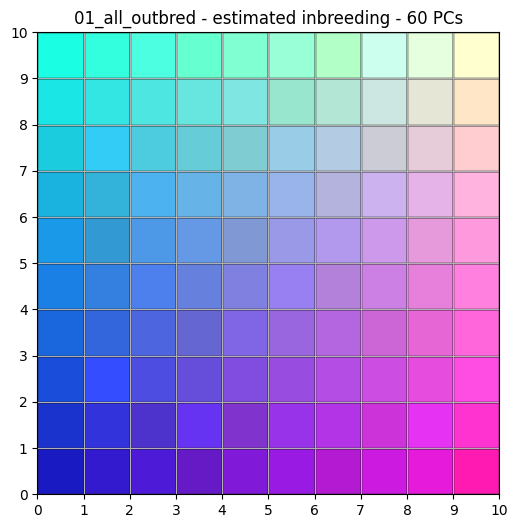

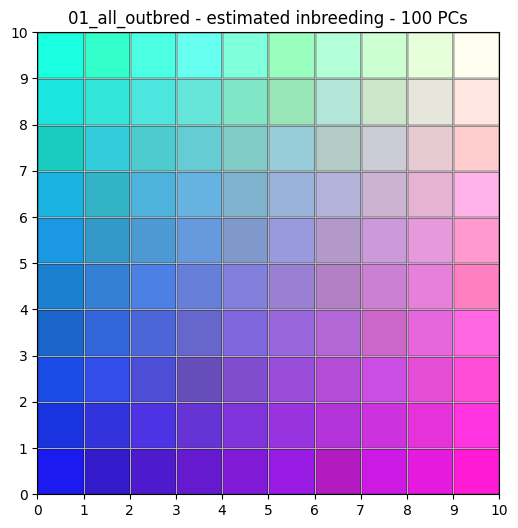

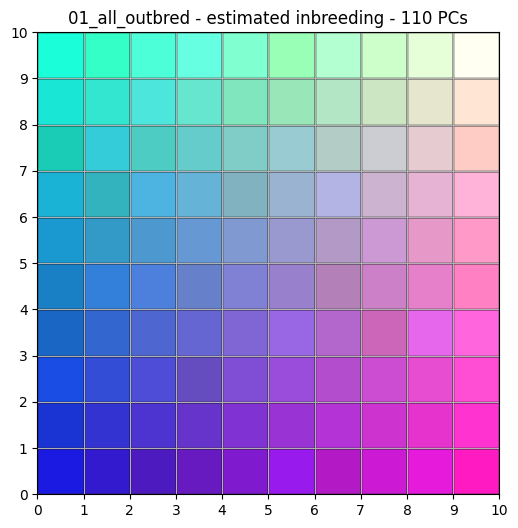

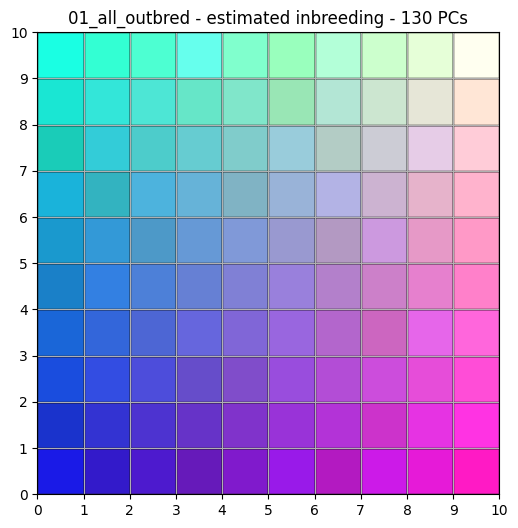

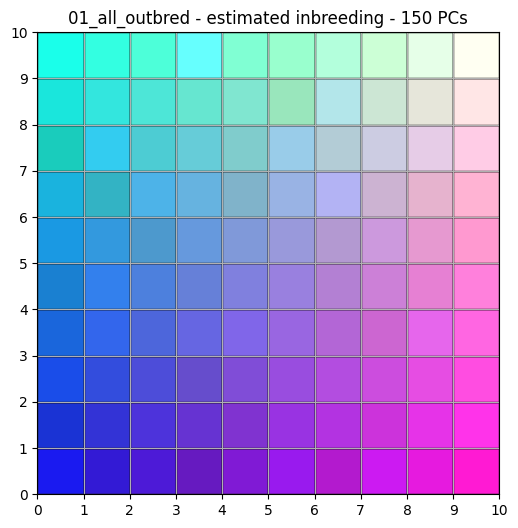

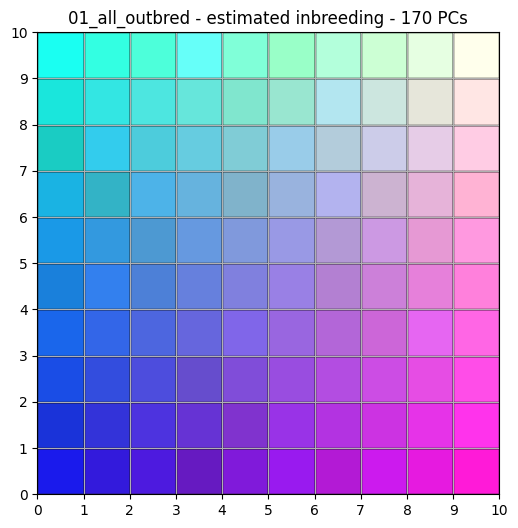

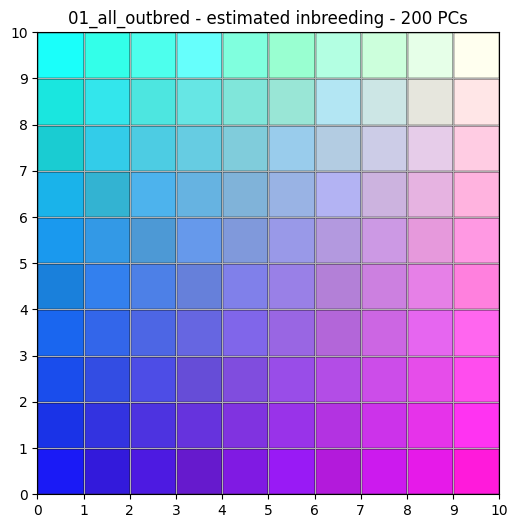

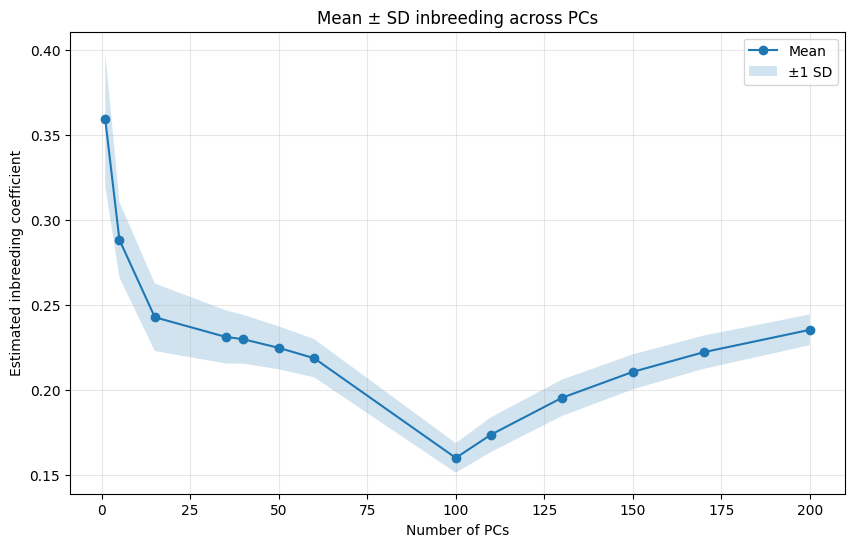

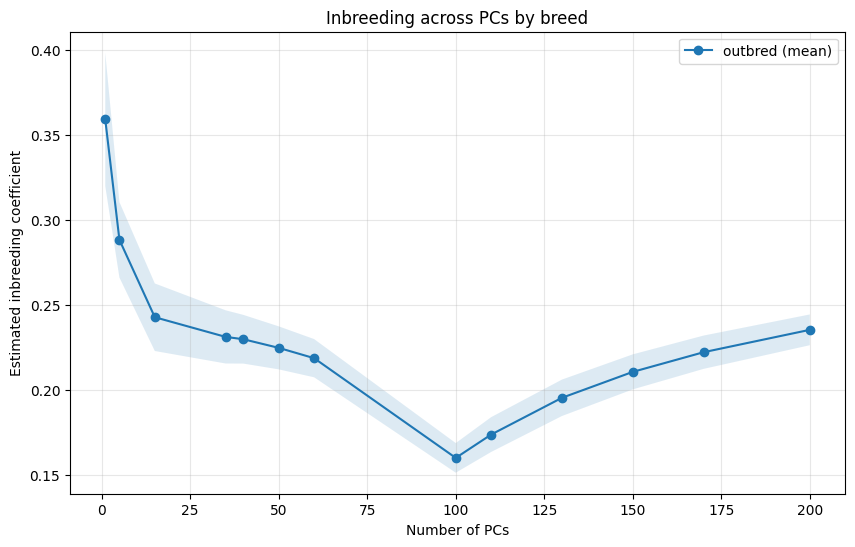

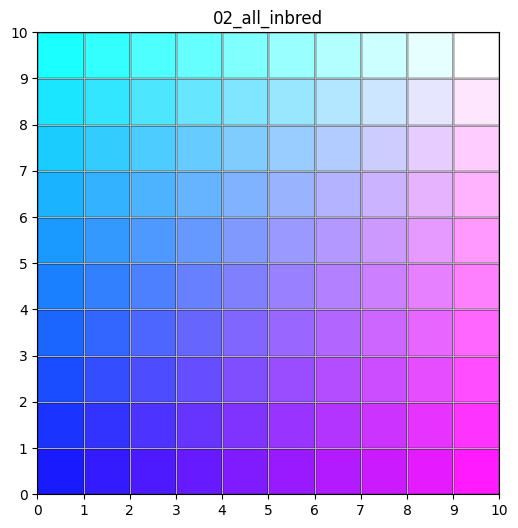

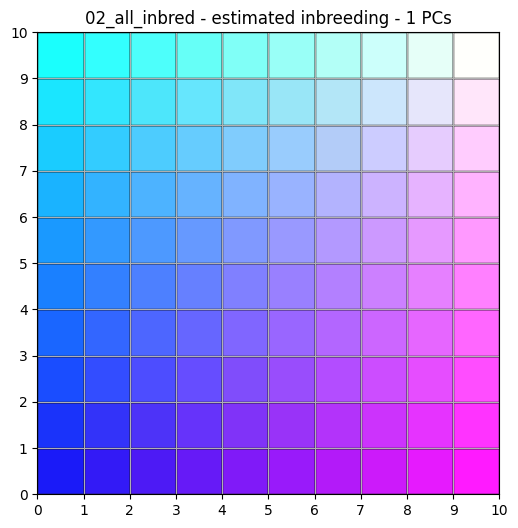

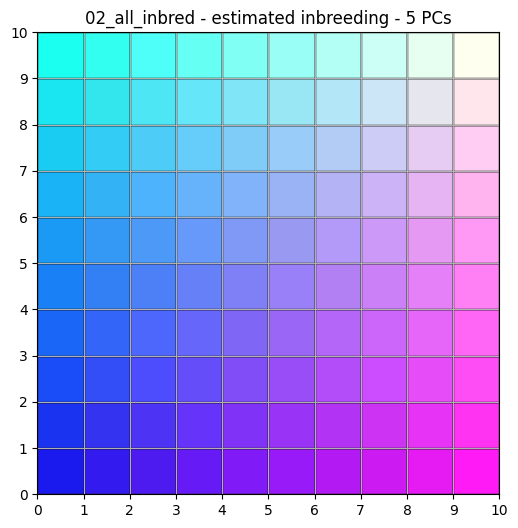

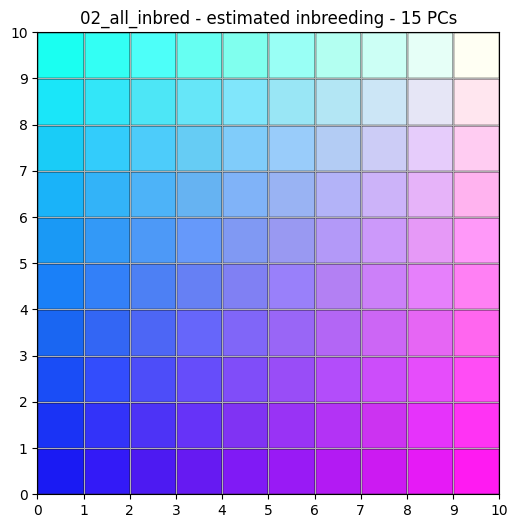

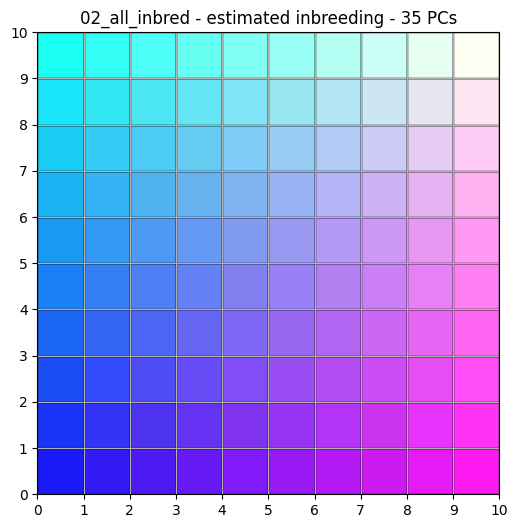

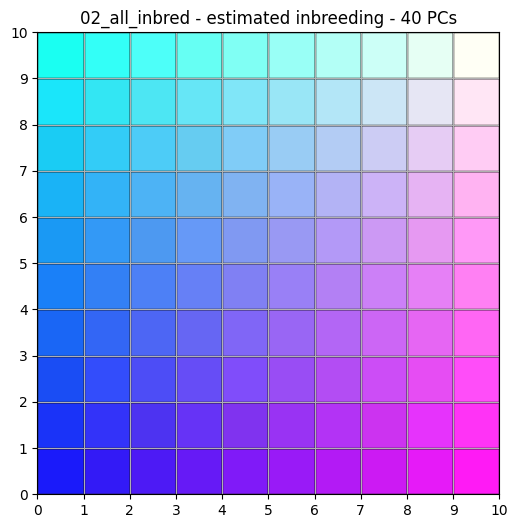

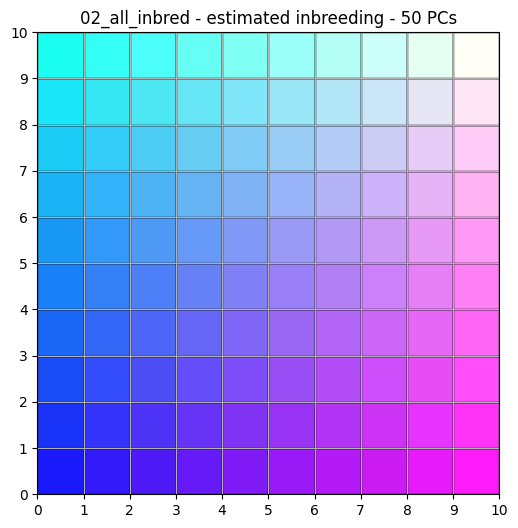

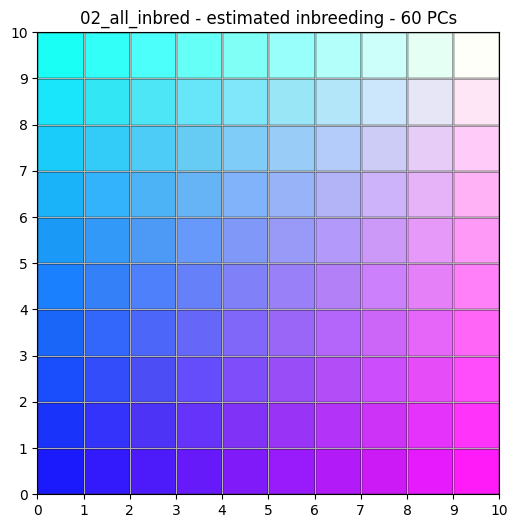

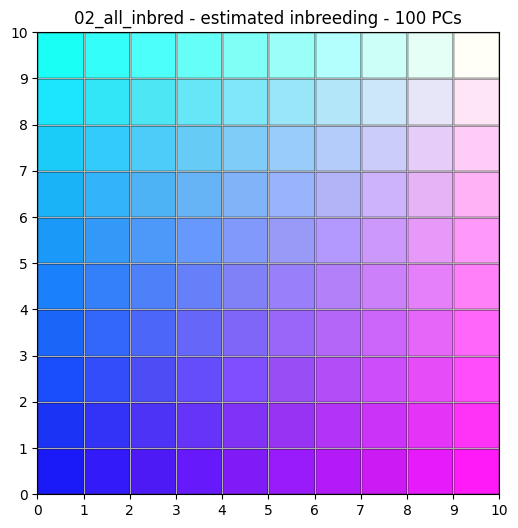

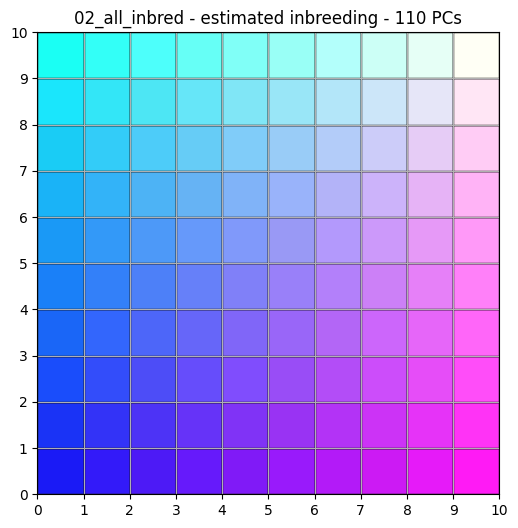

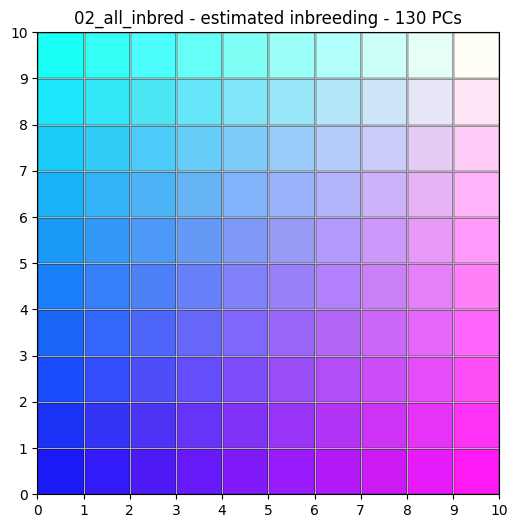

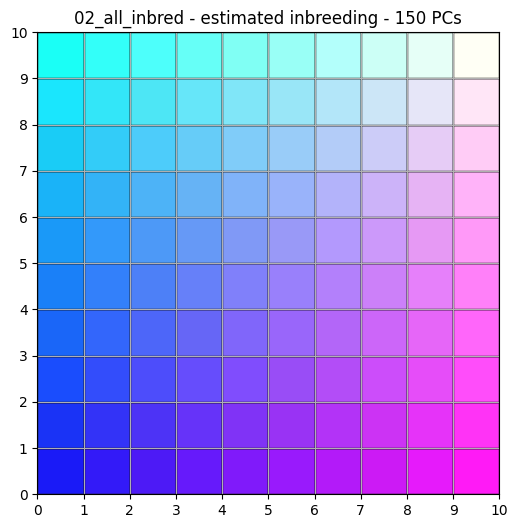

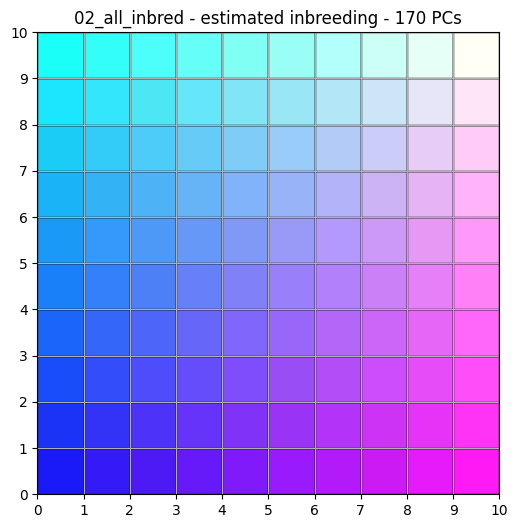

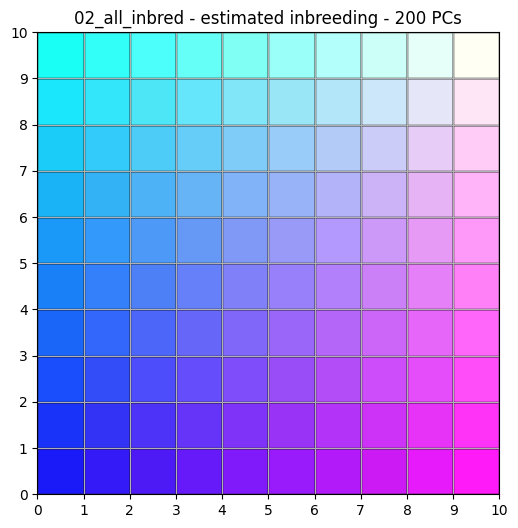

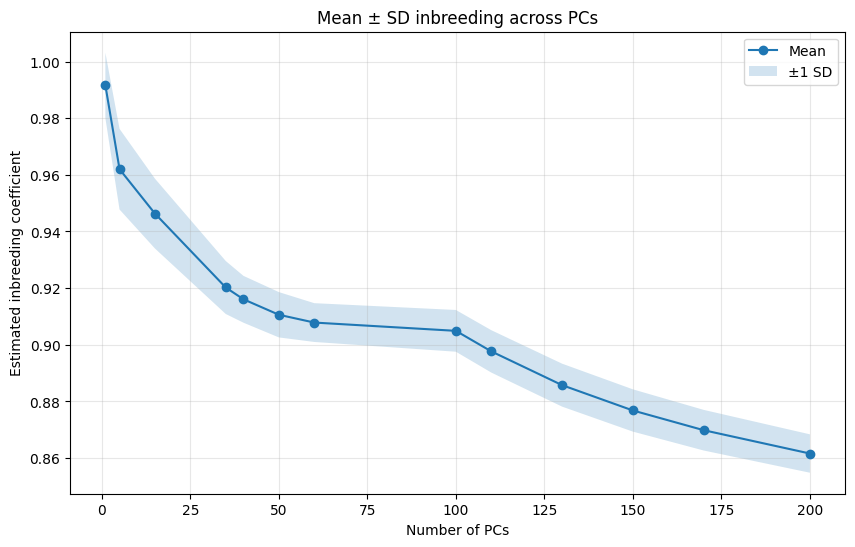

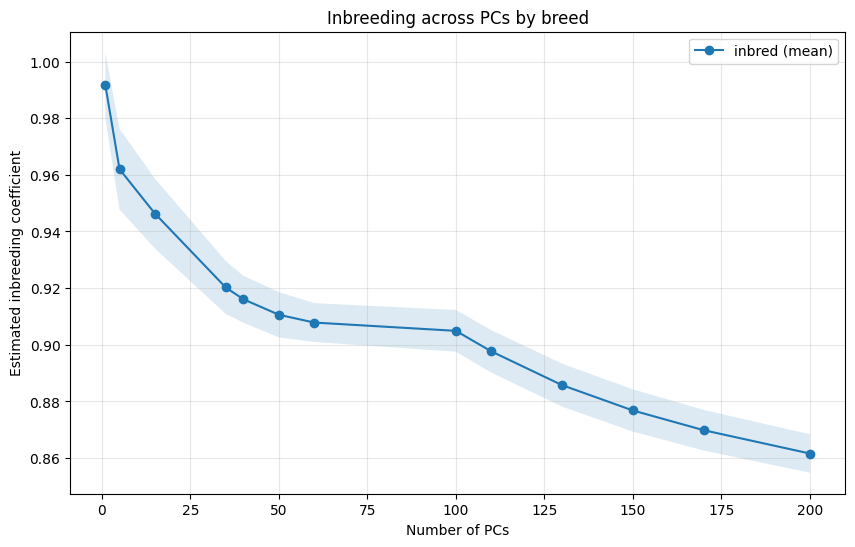

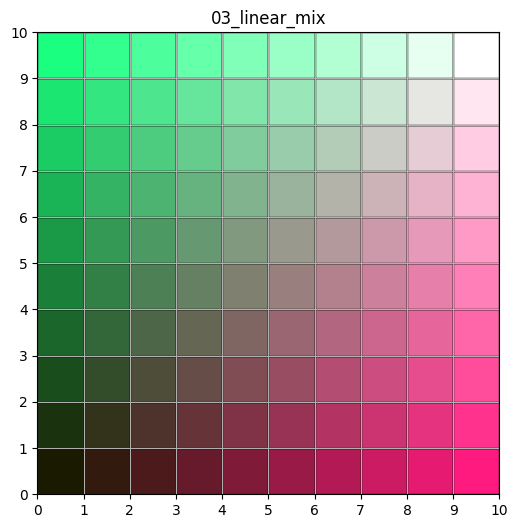

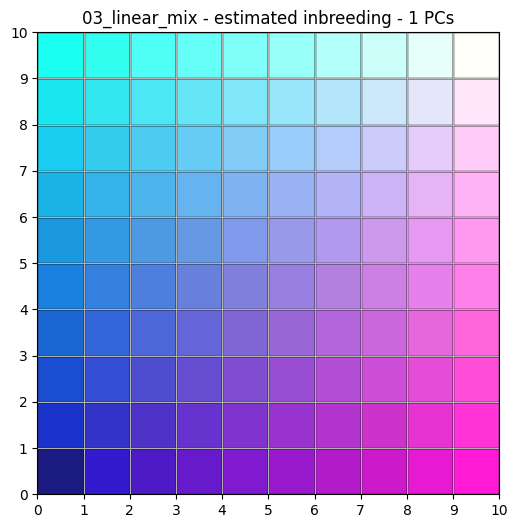

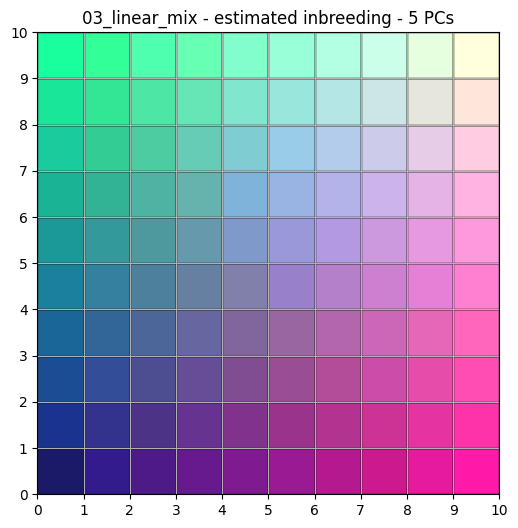

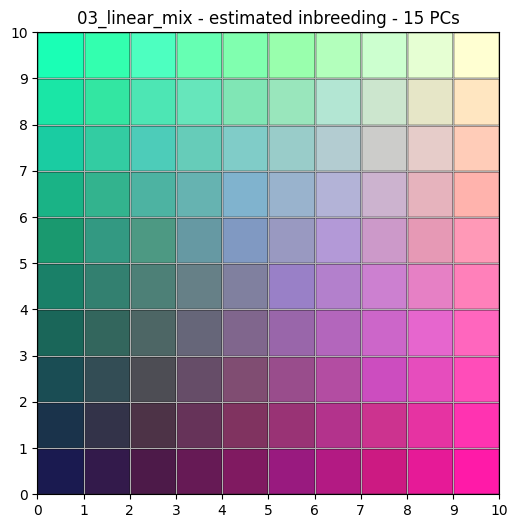

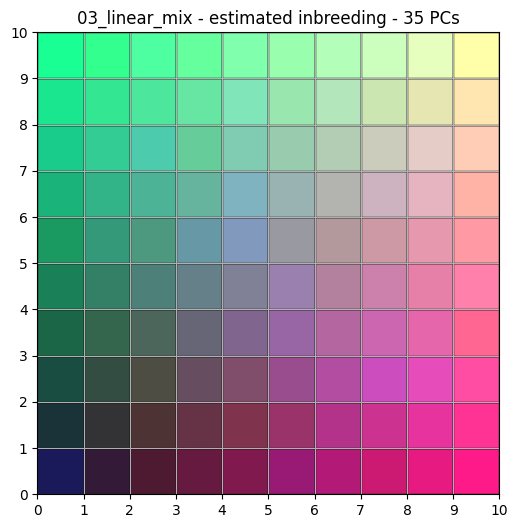

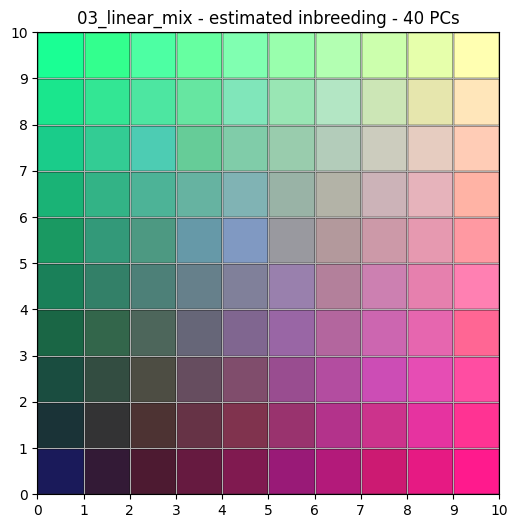

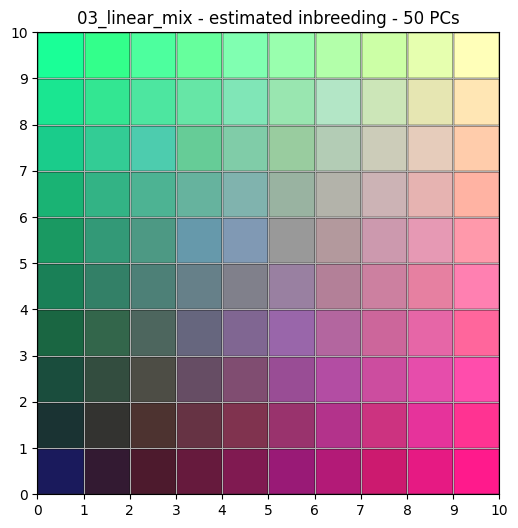

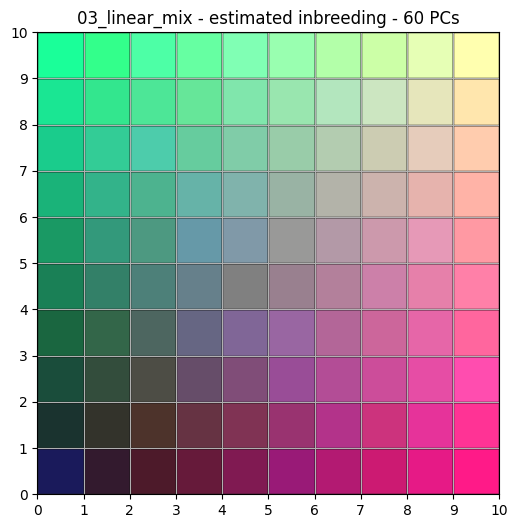

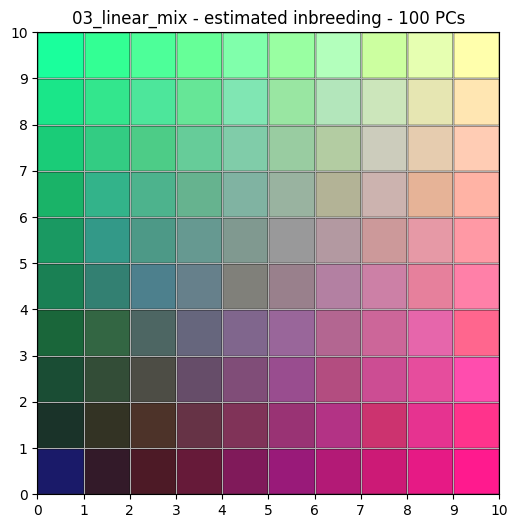

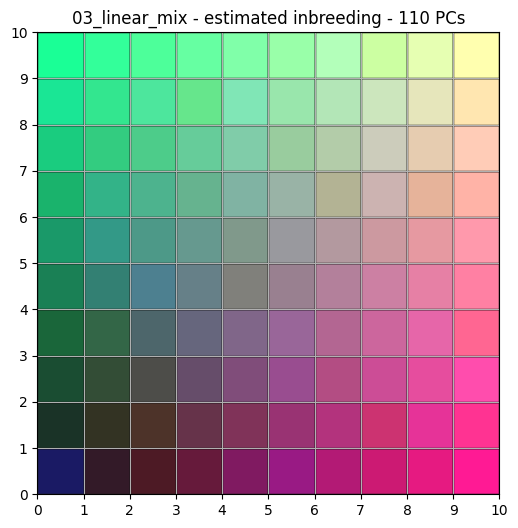

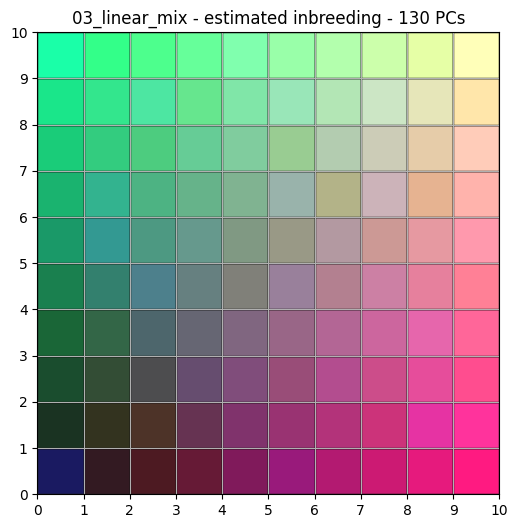

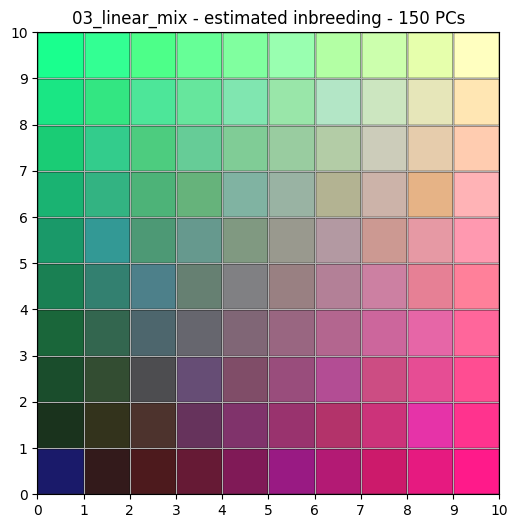

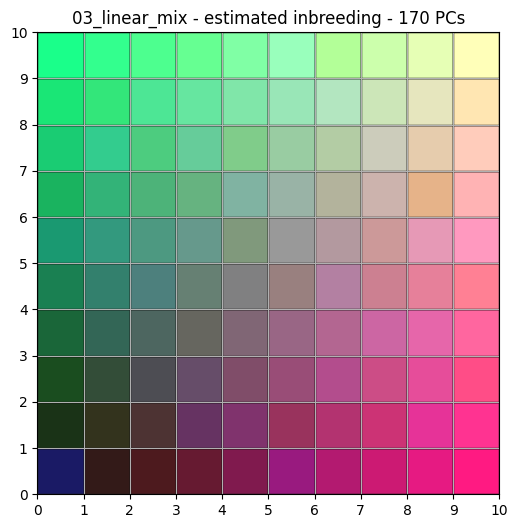

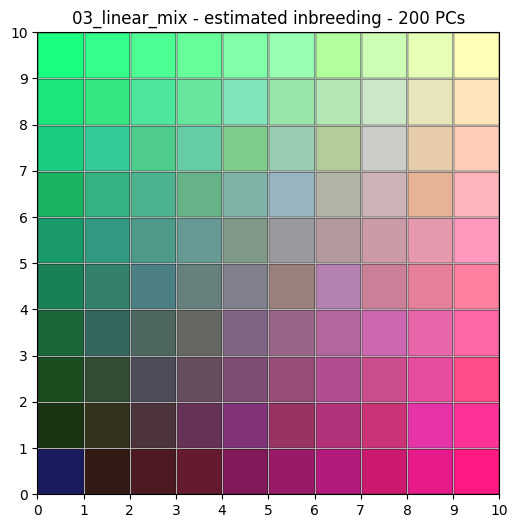

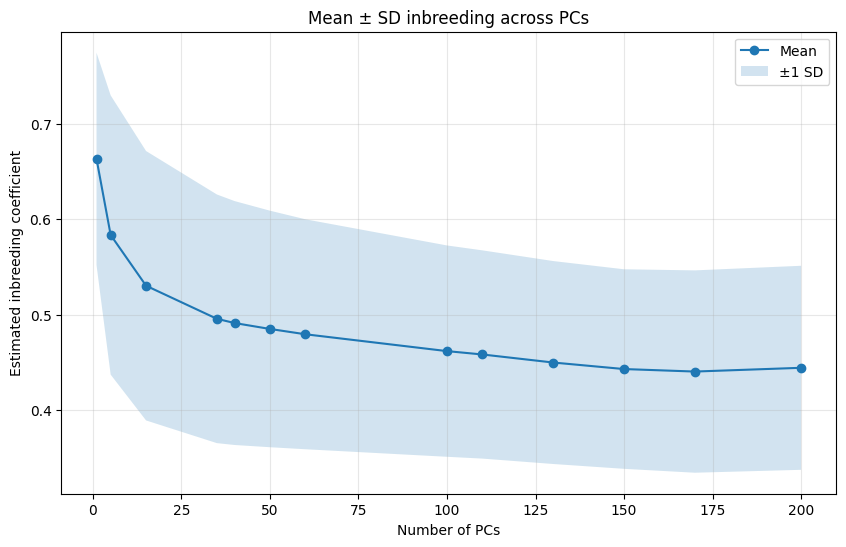

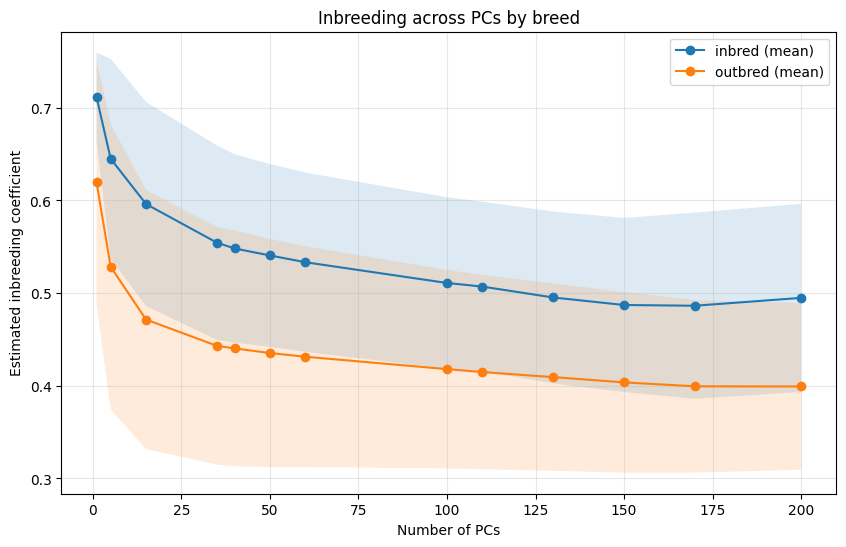

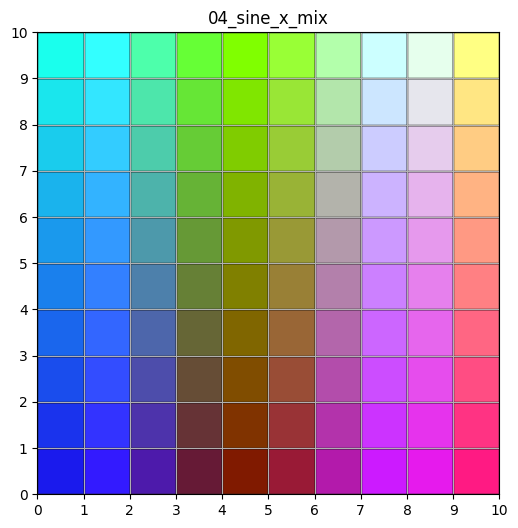

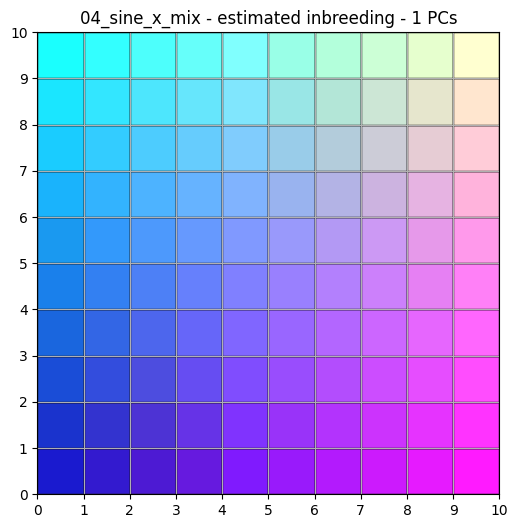

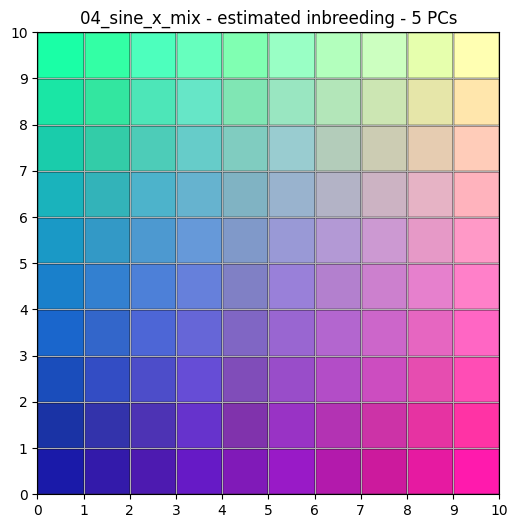

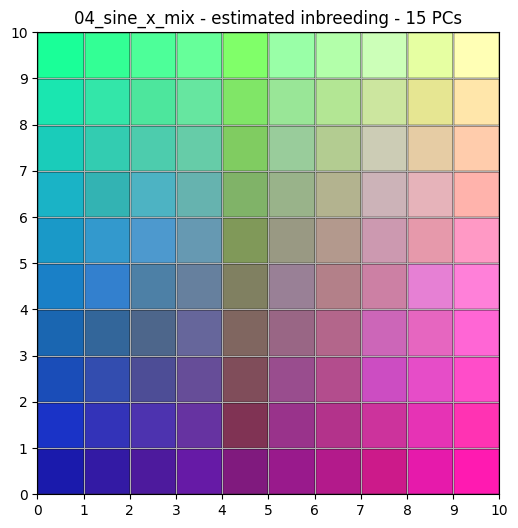

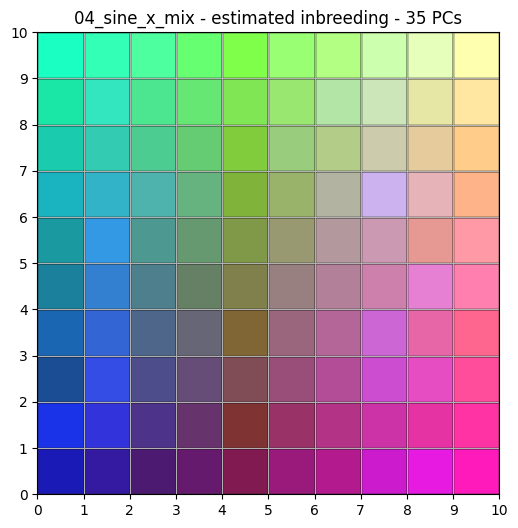

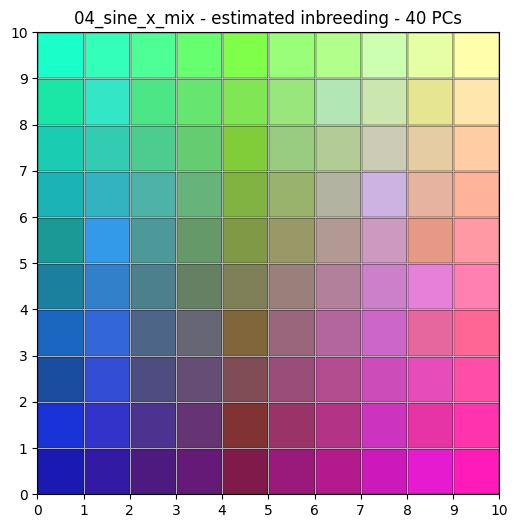

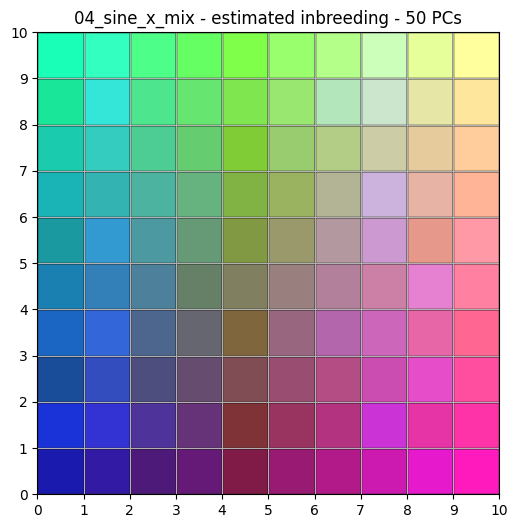

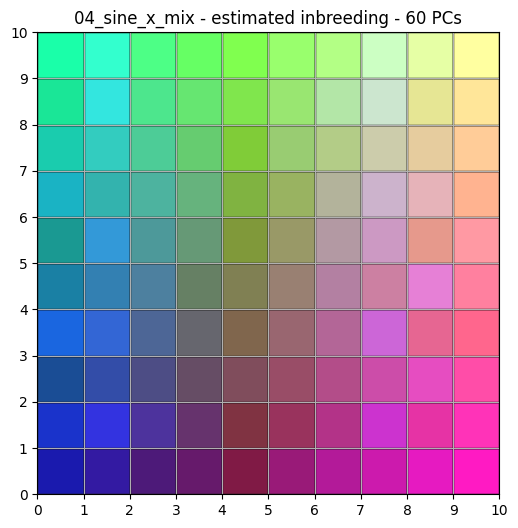

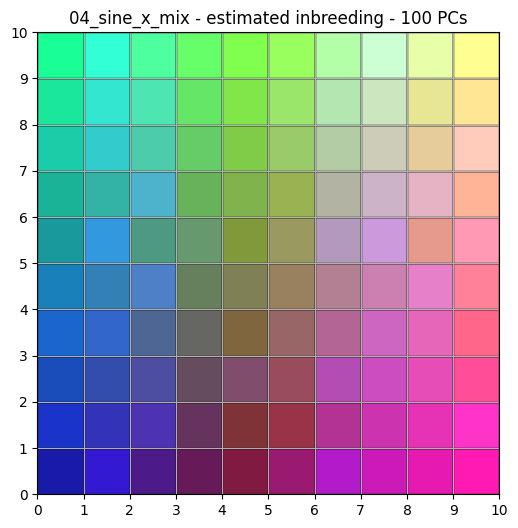

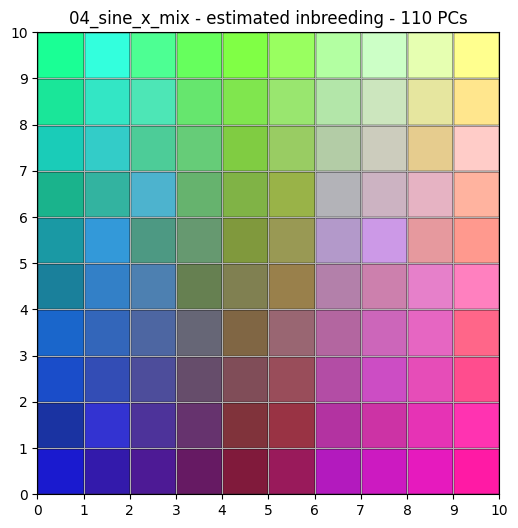

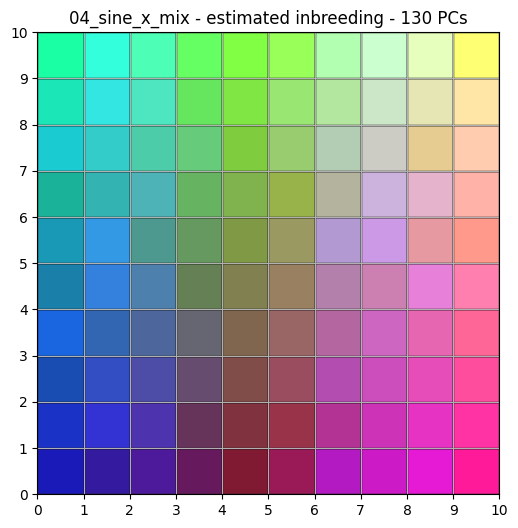

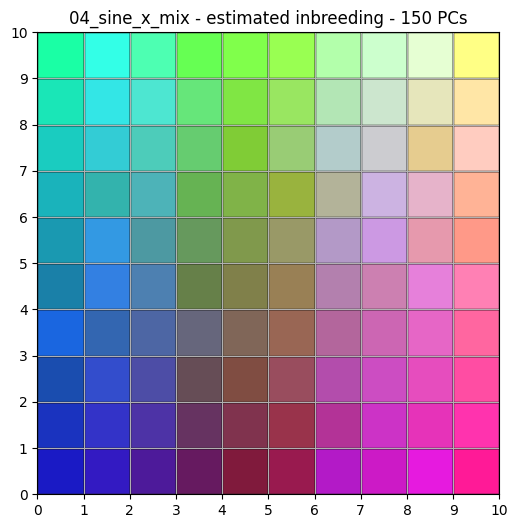

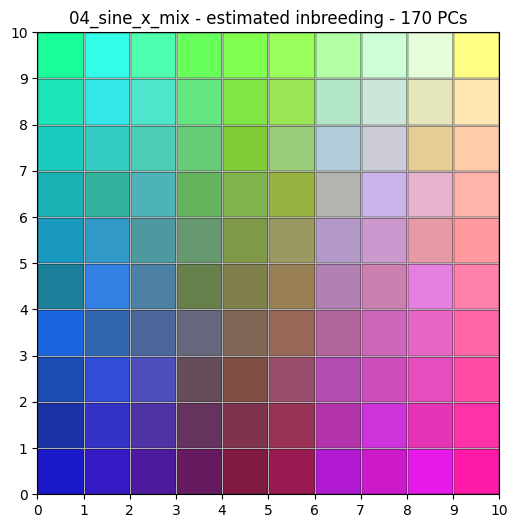

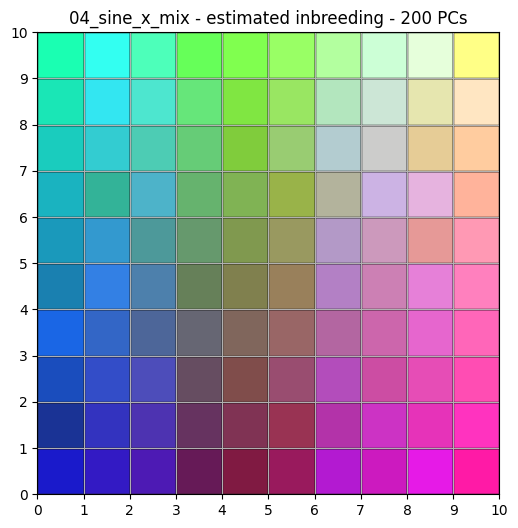

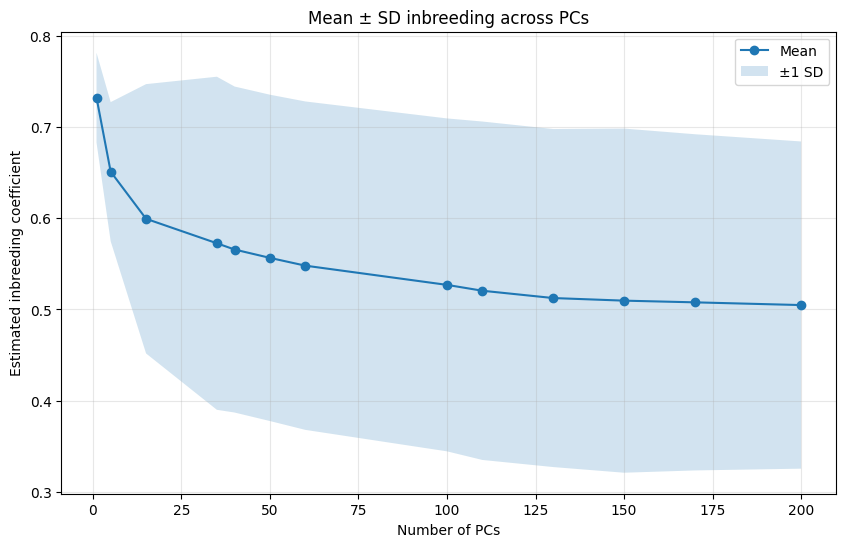

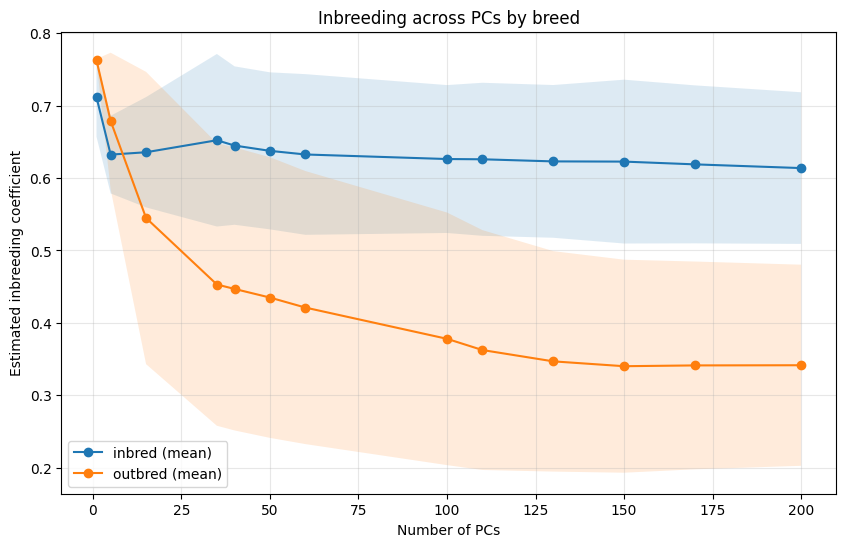

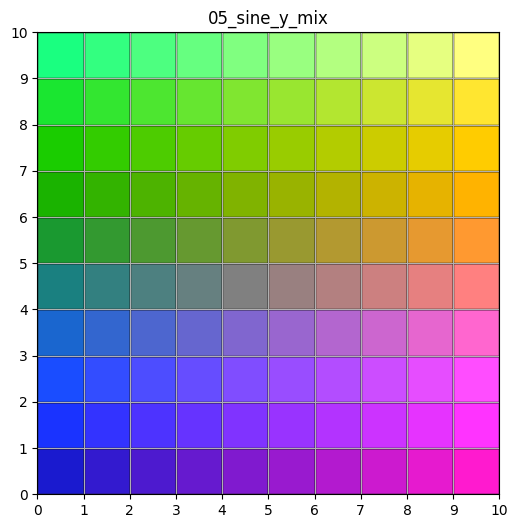

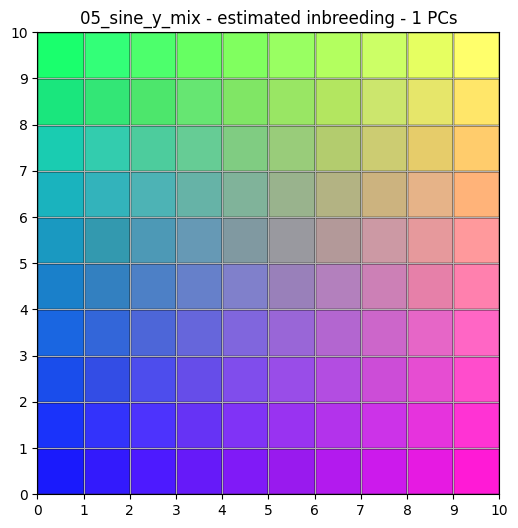

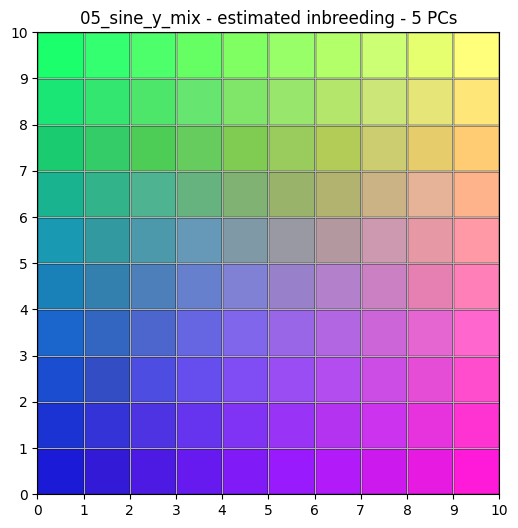

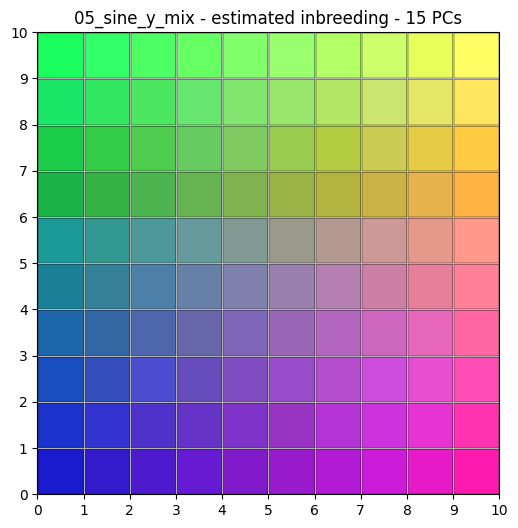

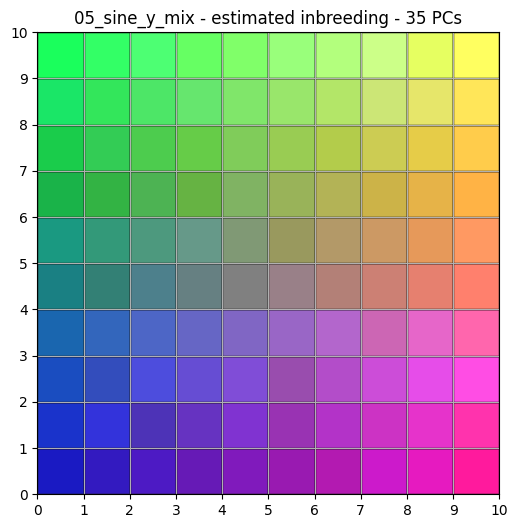

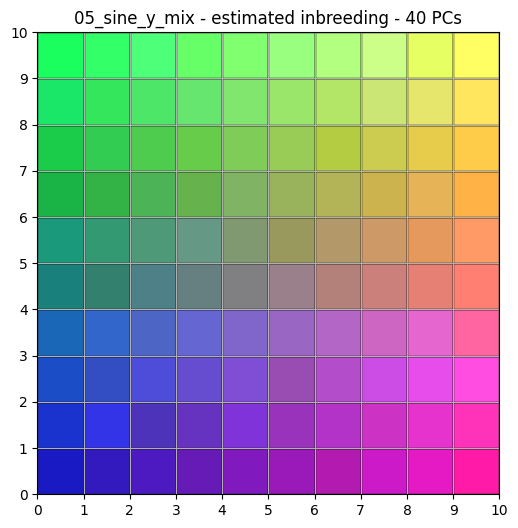

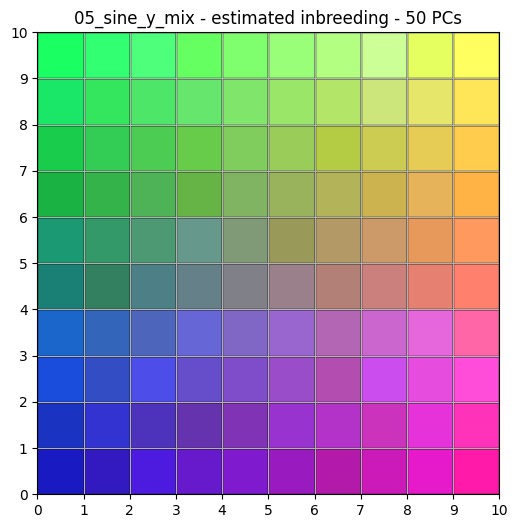

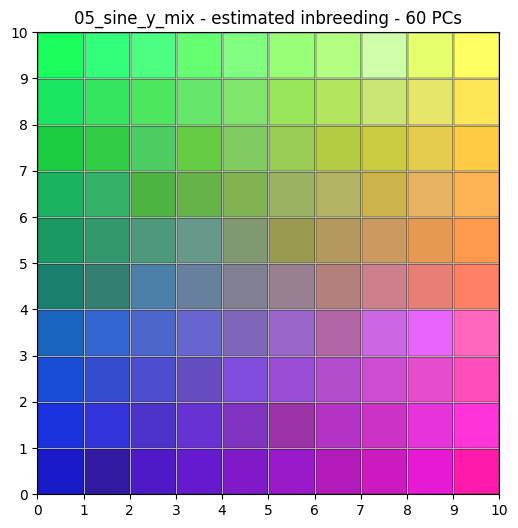

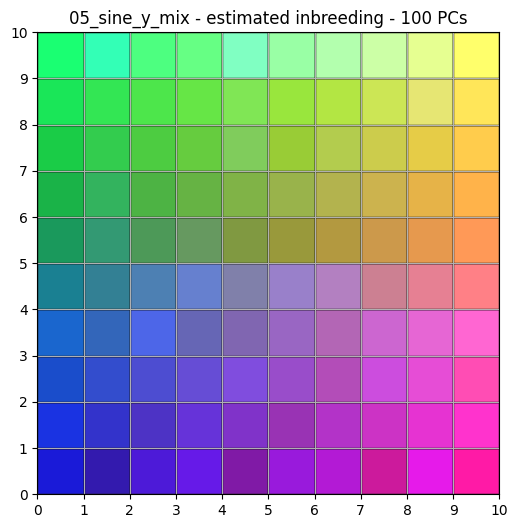

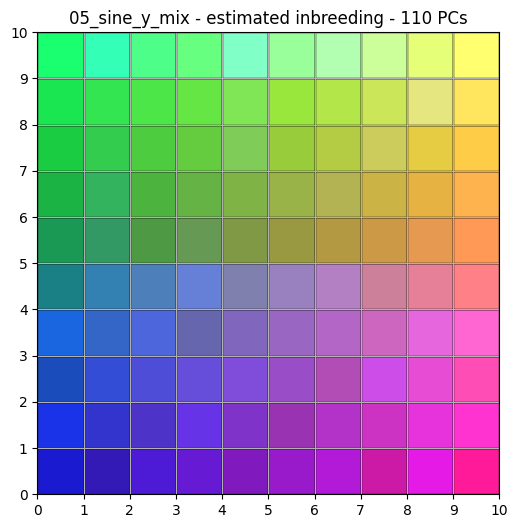

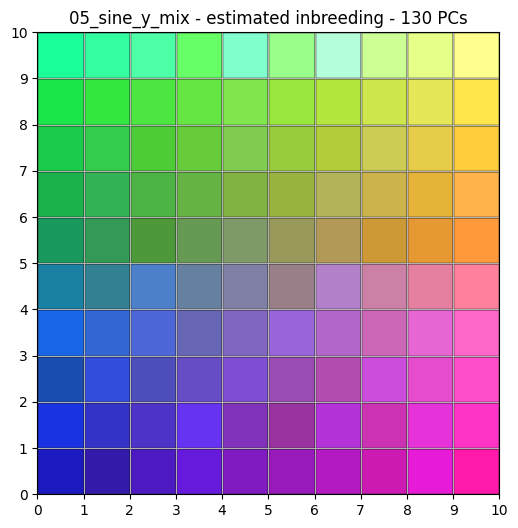

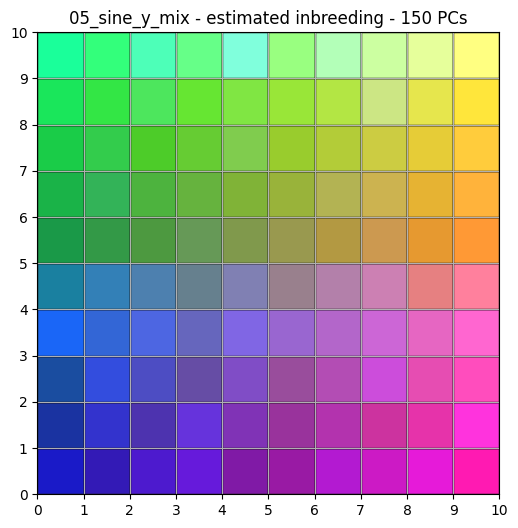

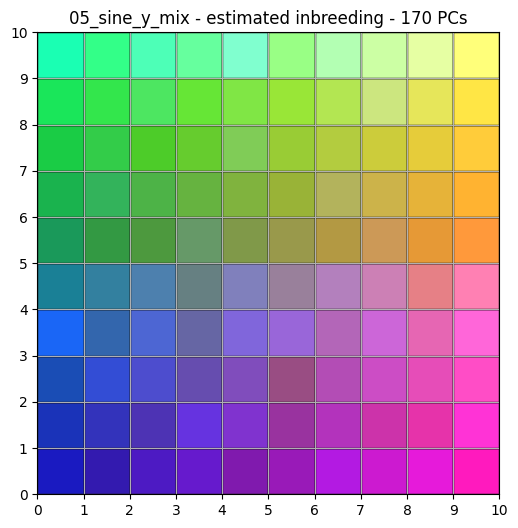

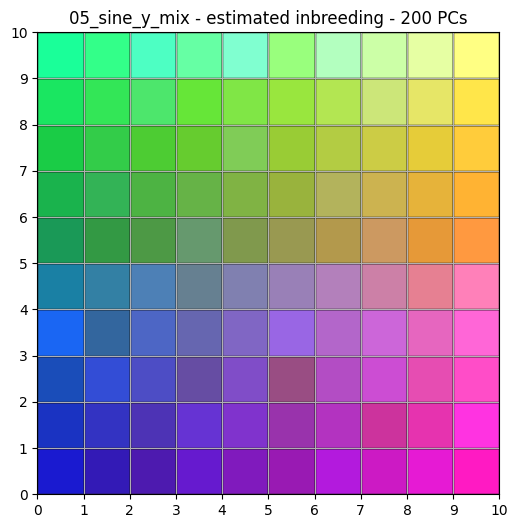

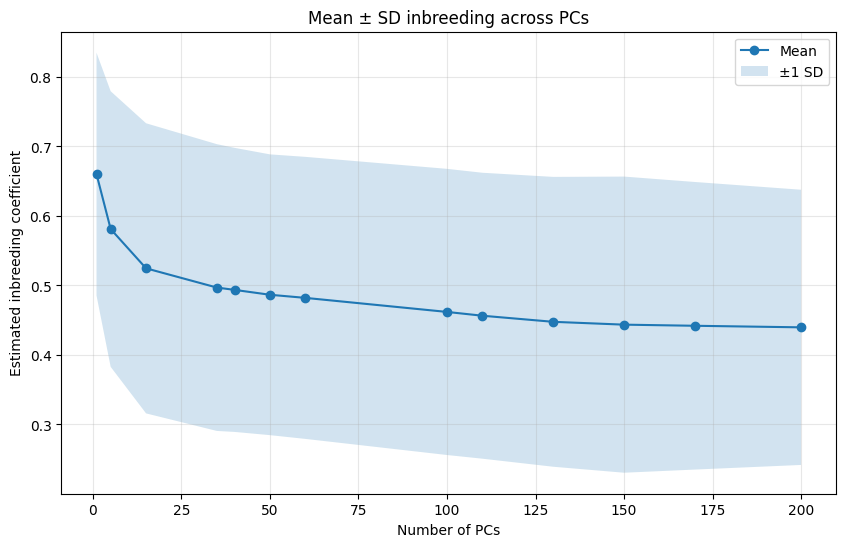

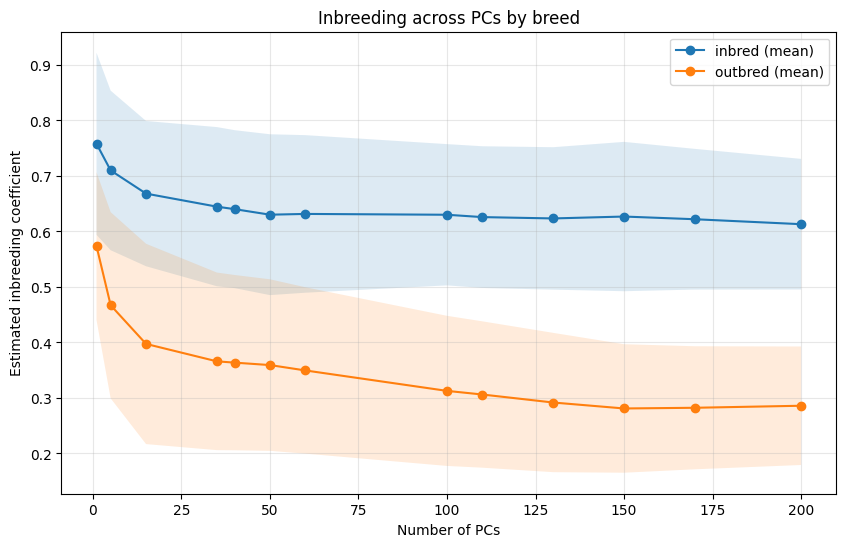

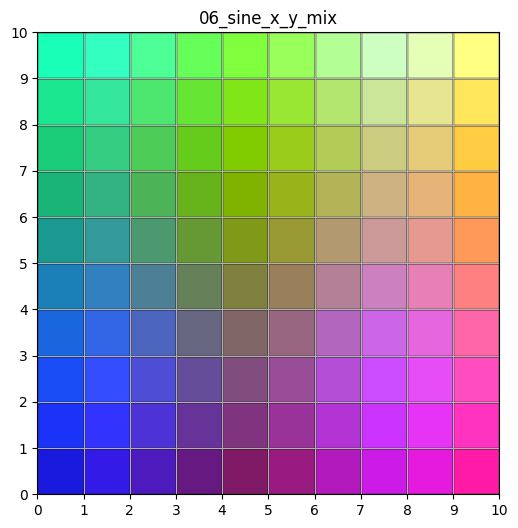

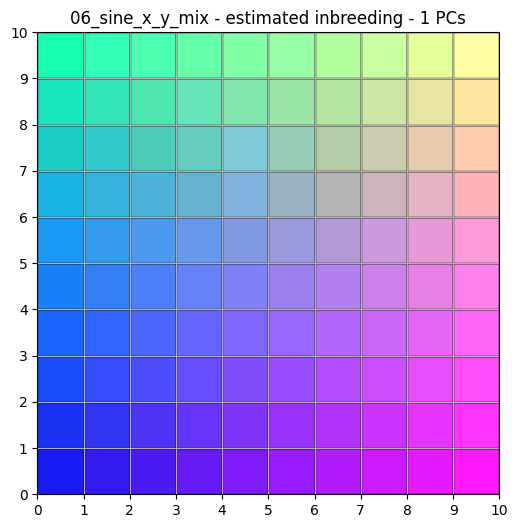

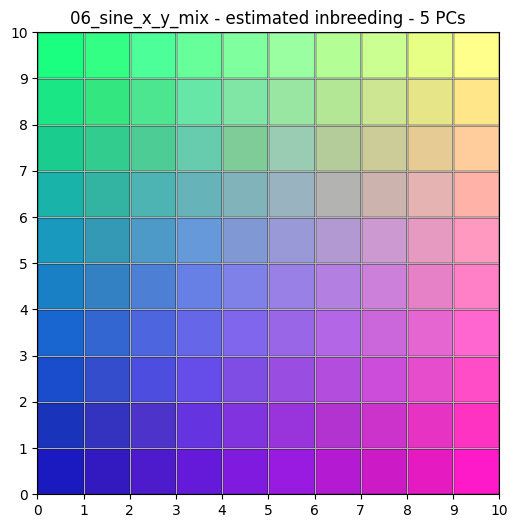

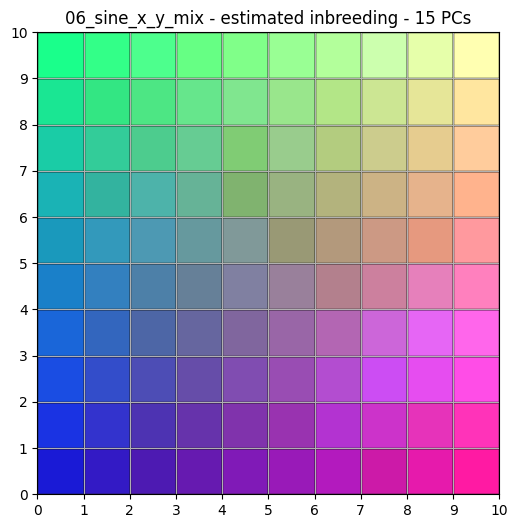

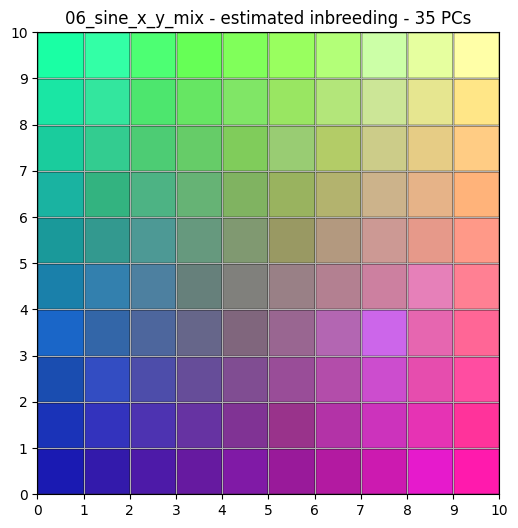

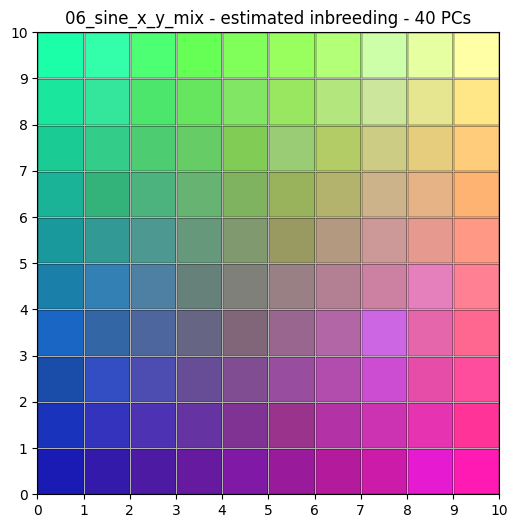

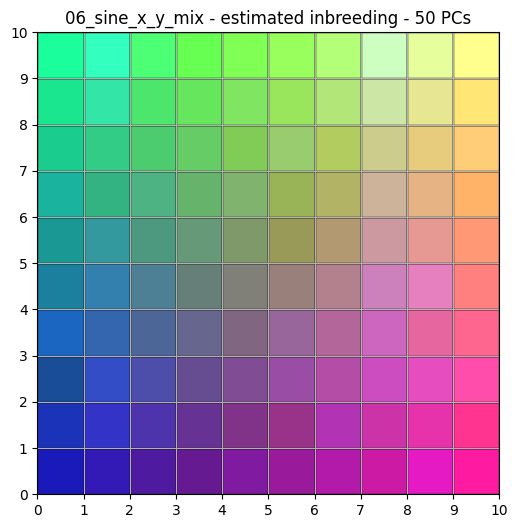

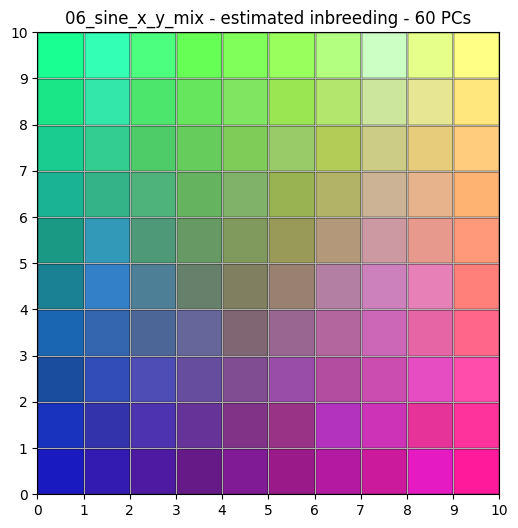

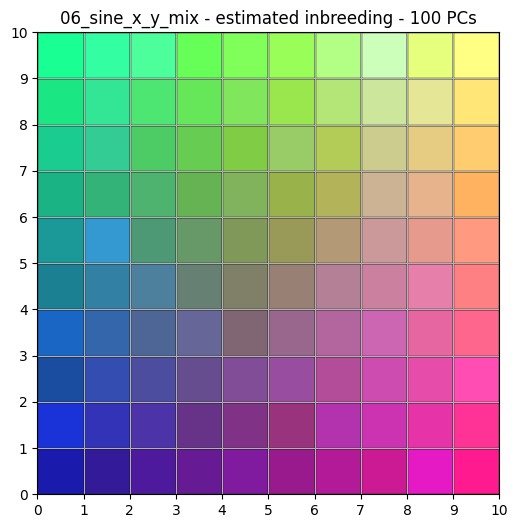

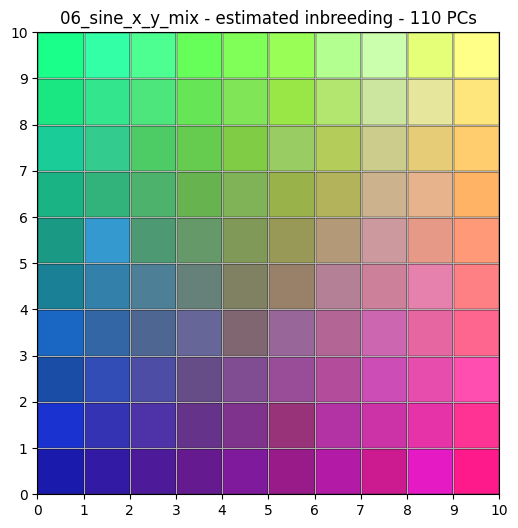

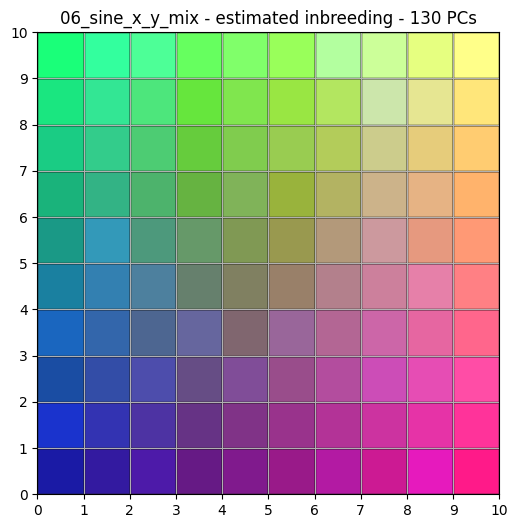

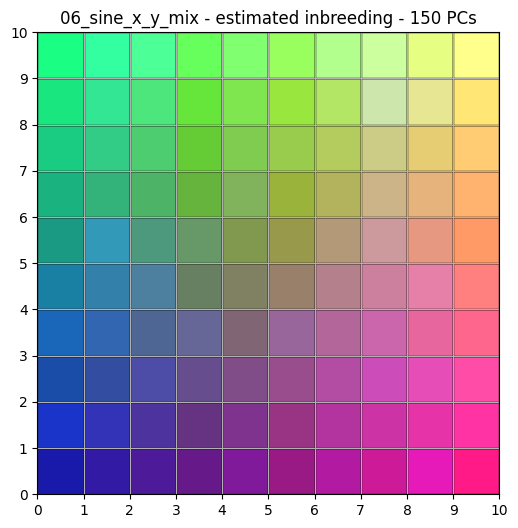

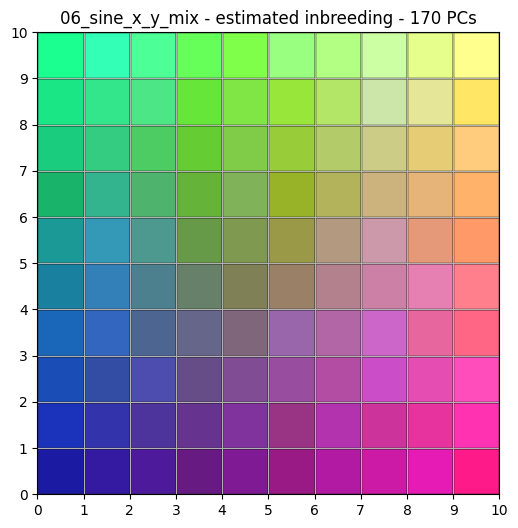

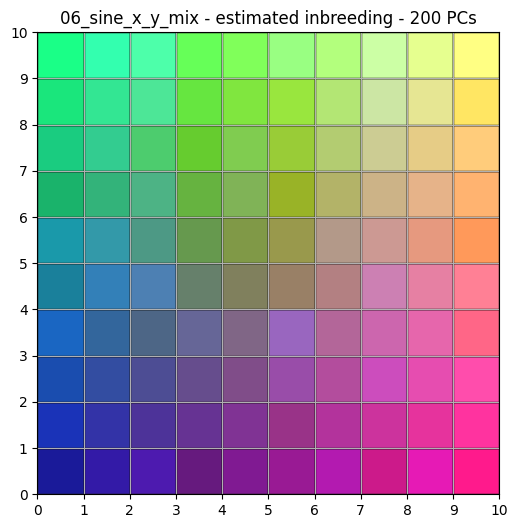

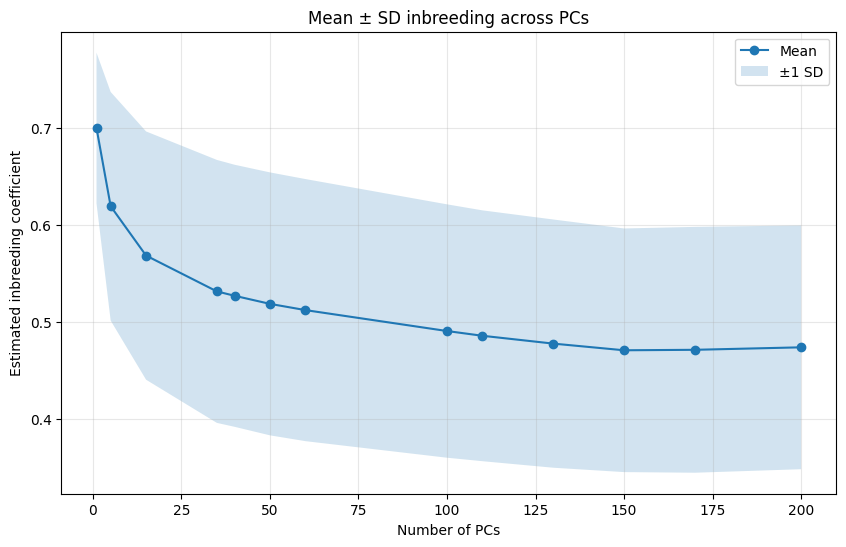

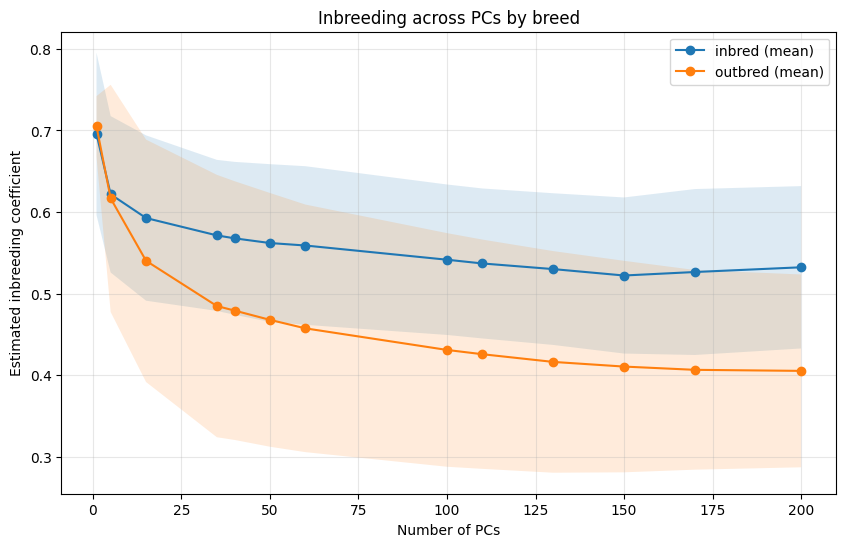

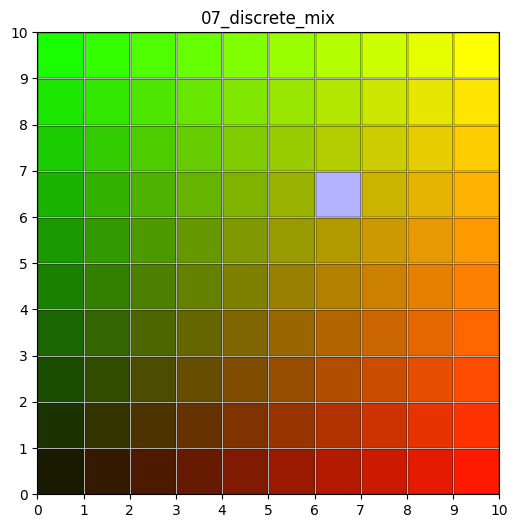

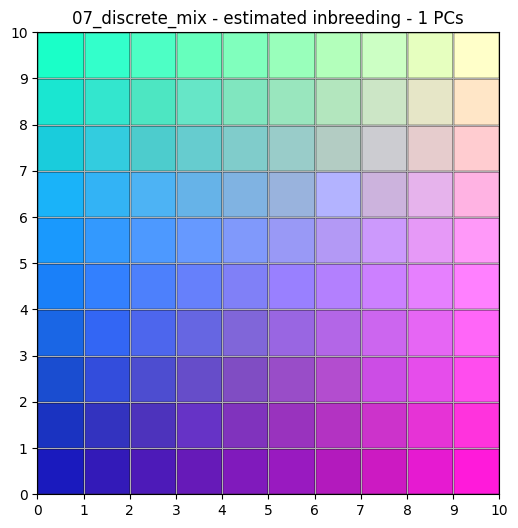

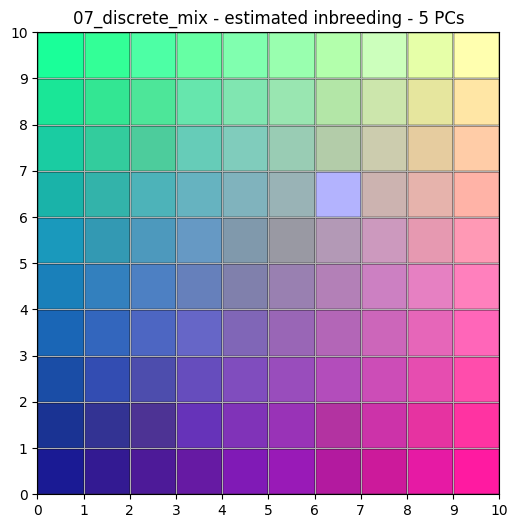

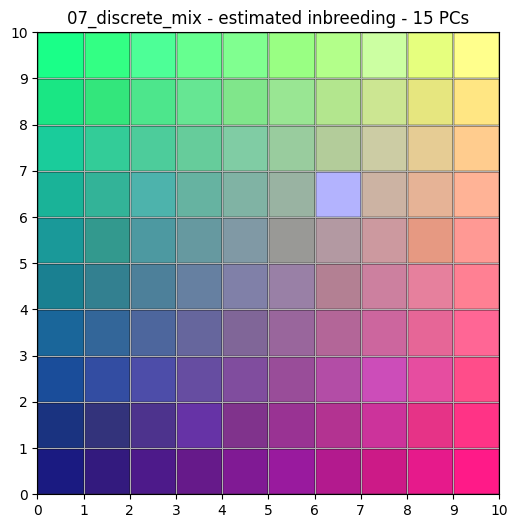

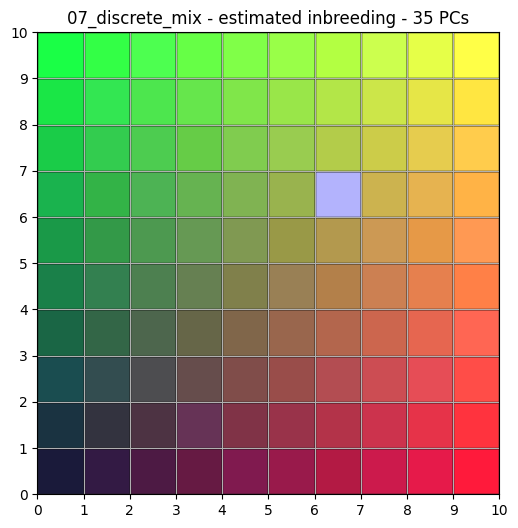

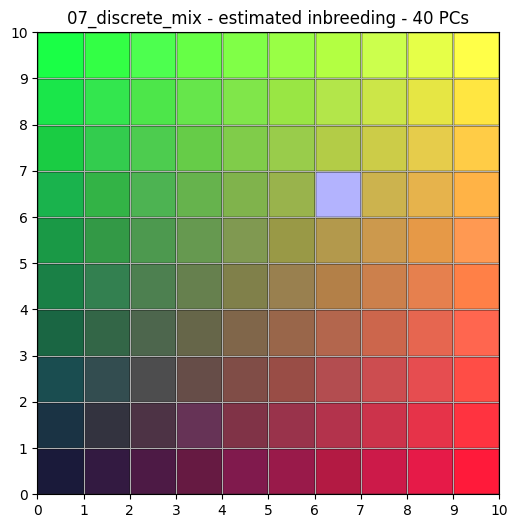

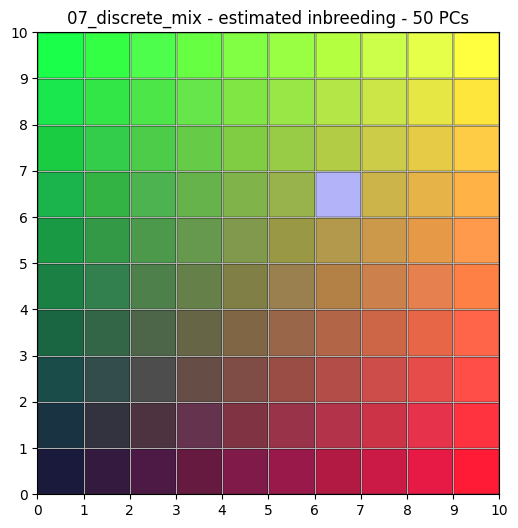

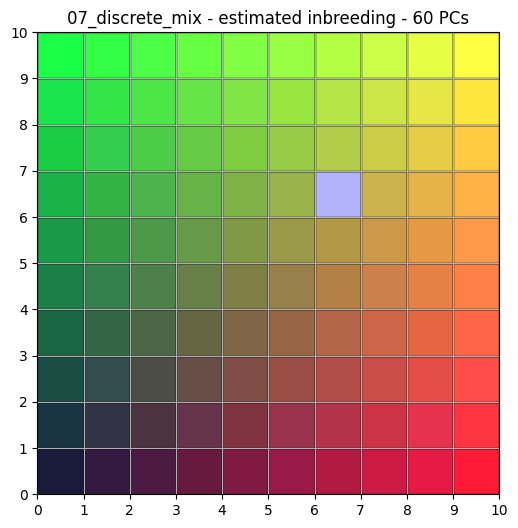

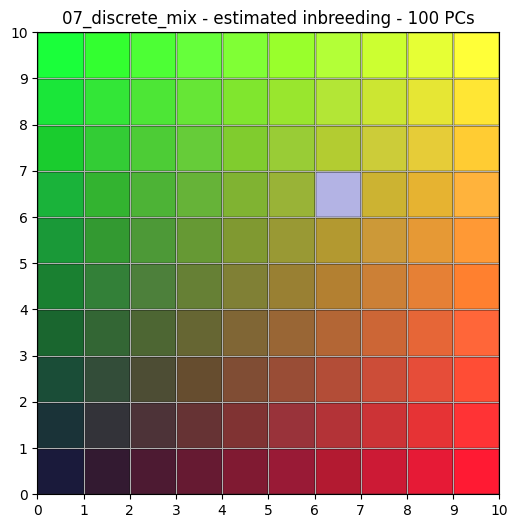

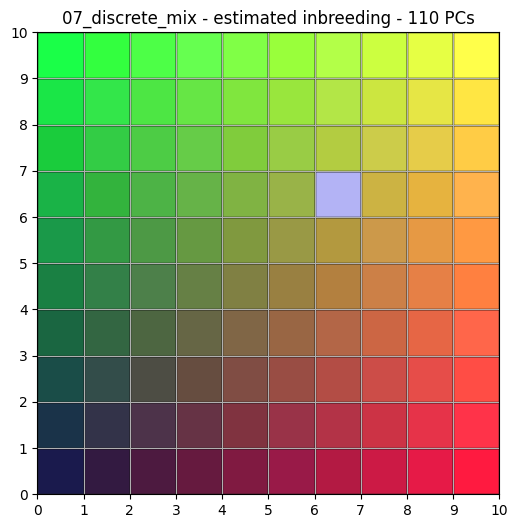

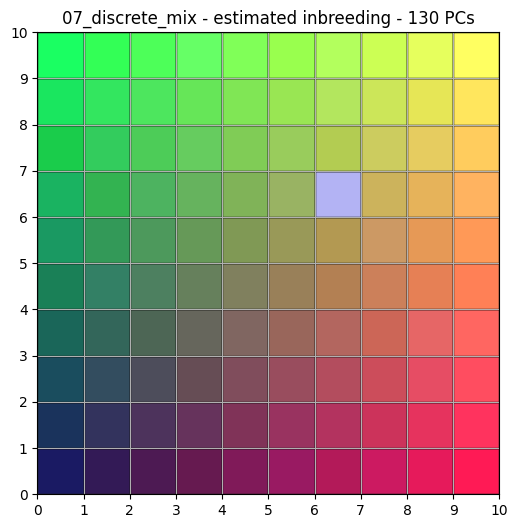

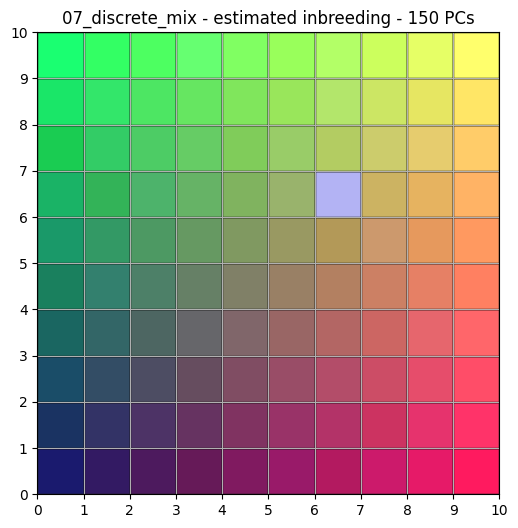

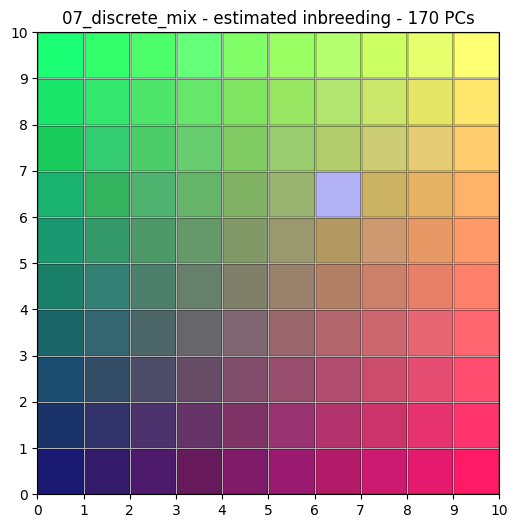

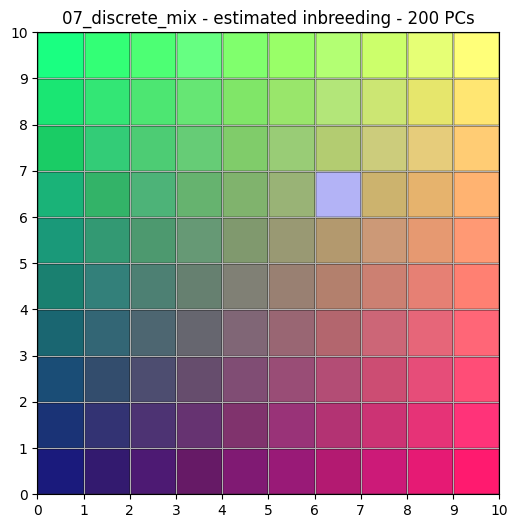

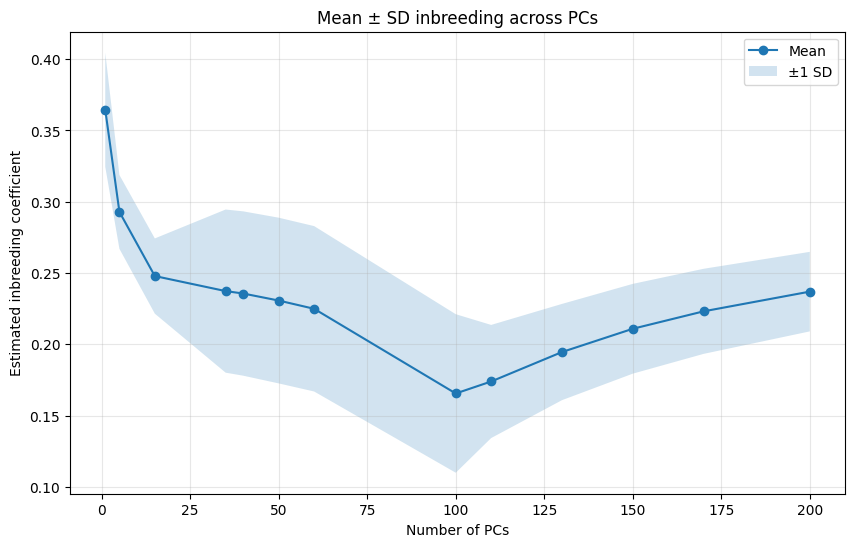

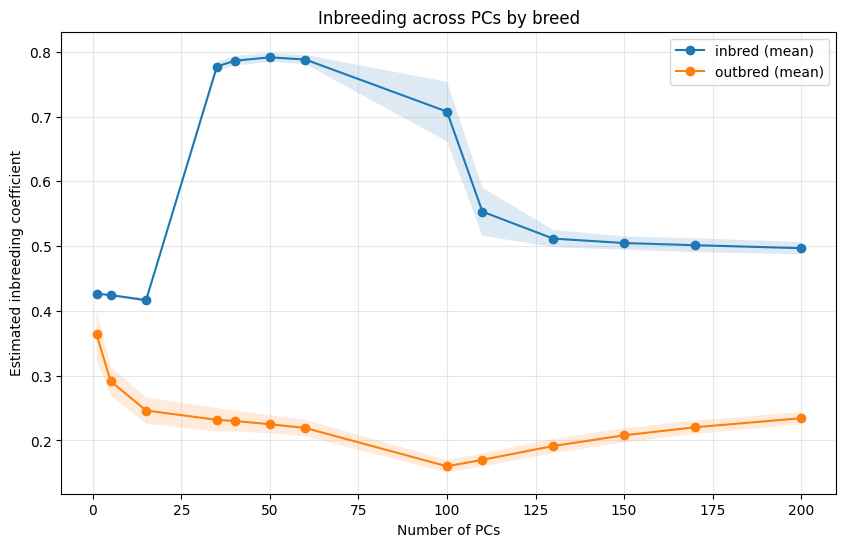

In [3]:
for mixed_case in mixed_cases:
    base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{mixed_case}"
    path_geno = f"{base_path}/genotype"
    geno = pd.read_pickle((f"{path_geno}/complete.pkl"))
    path_pcs = f"{base_path}/PCs"
    pc_files = [f for f in os.listdir(path_pcs) if re.match(r"^geno_\d", f)]
    pc_files = sorted(pc_files, key=lambda x: int(re.search(r'geno_(\d+)_PCs', x).group(1)))
    path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{mixed_case}/phenotype/"
    humans= pd.read_pickle(f"{path_pheno}/humans.pkl")


    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in range(k):
        for j in range(k):
            # pick the row for this grid cell
            row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
            # compute ONE color for this cell
            cell_color = map_to_color(row['x'], row['y'], row[mixed_case], humans, mixed_case)
    
            ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))
    
    ax.set_xlim(0, k)
    ax.set_ylim(0, k)
    ax.set_aspect('equal')
    ax.set_xticks(range(k + 1))
    ax.set_yticks(range(k + 1))
    ax.grid(True)
    plt.title(f"{mixed_case}")
    plt.show()
    
    for pc_file in pc_files:
        nr_pcs = int(pc_file.split("_")[1])
        path_pc = f"{path_pcs}/{pc_file}"
        PCs = pd.read_pickle(path_pc)
        common_idx = PCs.index.intersection(geno.index)
        PCs = PCs.loc[common_idx]
        geno = geno.loc[common_idx]
        het = (geno == 0).astype(int)
        pc_means = PCs.mean(axis=0)
        PCs_c = PCs - pc_means  # (n, k)
        n = PCs_c.shape[0]
        X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)
        
        B, residuals, rank, s = np.linalg.lstsq(X, geno.values, rcond=None)
        
        # 4) Extract M_mean (length = n_snps) and weights
        M_mean = pd.Series(B[0, :], index=geno.columns, name="maf_mean") 
        W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=geno.columns) 
        
        # 5) Reconstruct genotypes for the observed samples
        #    M_hat = 1·M_mean^T + PCs_c · W
        mu_hat  = X @ B
        mu_hat  = pd.DataFrame(mu_hat , index=geno.index, columns=geno.columns)
        p_hat  = np.clip((mu_hat + 1.0) / 2.0, 1e-6, 1 - 1e-6)
    
        n = PCs_c.shape[0]
        X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)
        
        B, residuals, rank, s = np.linalg.lstsq(X, het.values, rcond=None)
        
        # 4) Extract M_mean (length = n_snps) and weights
        het_mean = pd.Series(B[0, :], index=het.columns, name="het_mean")
        W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=het.columns) 
        
        # 5) Reconstruct genotypes for the observed samples
        #    M_hat = 1·M_mean^T + PCs_c · W
        het_hat  = X @ B
        het_hat  = pd.DataFrame(het_hat , index=het.index, columns=het.columns)
        het_hat = np.clip(het_hat, 1e-6, 1 - 1e-6)
        
        denom = 2 * p_hat * (1 - p_hat)
        F_hat   = np.clip(1 - het_hat/denom, 0, 1)
        humans[f"estimated_inbreeding_{nr_pcs}_PCs"] = F_hat.mean(axis=1)



        fig, ax = plt.subplots(figsize=(6, 6))
        
        for i in range(k):
            for j in range(k):
                # pick the row for this grid cell
                row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
                # compute ONE color for this cell
                cell_color = map_to_color(row['x'], row['y'], row[f"estimated_inbreeding_{nr_pcs}_PCs"], humans, f"estimated_inbreeding_{nr_pcs}_PCs")
        
                ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))
        
        ax.set_xlim(0, k)
        ax.set_ylim(0, k)
        ax.set_aspect('equal')
        ax.set_xticks(range(k + 1))
        ax.set_yticks(range(k + 1))
        ax.grid(True)
        plt.title(f"{mixed_case} - estimated inbreeding - {nr_pcs} PCs")
        plt.show()

    #row = humans.iloc[2] #example


    pc_cols = [c for c in humans.columns if c.startswith("estimated_inbreeding_")]
    pc_pairs = [(int(re.search(r"estimated_inbreeding_(\d+)_PCs", c).group(1)), c) for c in pc_cols]
    pc_pairs.sort(key=lambda x: x[0])
    pc_labels = [k for k, _ in pc_pairs]
    #inbreeding_values = [row[c] for _, c in pc_pairs]
    
    #plt.figure(figsize=(8,5))
    #plt.plot(pc_labels, inbreeding_values, marker="o")
    #plt.xlabel("Number of PCs")
    #plt.ylabel("Estimated inbreeding coefficient")
    #plt.title(f"Inbreeding across PCs (individual index {row.name})")
    #plt.grid(True, alpha=0.3)
    #plt.show()


    vals = humans[[c for _, c in pc_pairs]]
    means = vals.mean(axis=0).values
    stds  = vals.std(axis=0).values
    
    plt.figure(figsize=(10,6))
    plt.plot(pc_labels, means, marker="o", label="Mean")
    plt.fill_between(pc_labels, means - stds, means + stds, alpha=0.2, label="±1 SD")
    plt.xlabel("Number of PCs")
    plt.ylabel("Estimated inbreeding coefficient")
    plt.title("Mean ± SD inbreeding across PCs")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(10,6))

    for grp, gdf in humans.groupby("breed"):
        gvals = gdf[[c for _, c in pc_pairs]]
        gmean = gvals.mean(axis=0).values
        gsd   = gvals.std(axis=0).values
        plt.plot(pc_labels, gmean, marker="o", label=f"{grp} (mean)")
        plt.fill_between(pc_labels, gmean - gsd, gmean + gsd, alpha=0.15)
    
    plt.xlabel("Number of PCs")
    plt.ylabel("Estimated inbreeding coefficient")
    plt.title("Inbreeding across PCs by breed")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

